In [1]:
# Reload modules automatically
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
import logging

import matplotlib.pyplot as plt
import numpy as np
import torch
from strn_and_rbstness.data import GraphDataset, split
from strn_and_rbstness.helper.utils import accuracy
from strn_and_rbstness.models import create_model
from strn_and_rbstness.train import _train
from attacks import LocalAttack
from utils import get_sbm_model

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Experiment Code

In [15]:
def print_prediction_statistics(c_acc_bayes_l, c_acc_gnn_l, c_acc_bayes_structure_l,
                                c_acc_bayes_feature_l, c_acc_bayes_gnn_l, 
                                c_acc_bayes_not_gnn_l, c_acc_gnn_not_bayes_l):
    print(f"Prediction Statistics:")
    print(f"Count BC: {np.mean(c_acc_bayes_l):.1f}+-{np.std(c_acc_bayes_l):.1f}; "
          f"GNN: {np.mean(c_acc_gnn_l):.1f}+-{np.std(c_acc_gnn_l):.1f}")
    print(f"Count Structure BC: {np.mean(c_acc_bayes_structure_l):.1f}+-{np.std(c_acc_bayes_structure_l):.1f}; "
          f"Feature BC: {np.mean(c_acc_bayes_feature_l):.1f}+-{np.std(c_acc_bayes_feature_l):.1f}")
    print(f"Count BC and GNN: {np.mean(c_acc_bayes_gnn_l):.1f}+-{np.std(c_acc_bayes_gnn_l):.1f} ")
    print(f"Count BC not GNN: {np.mean(c_acc_bayes_not_gnn_l):.1f}+-{np.std(c_acc_bayes_not_gnn_l):.1f}; "
          f"GNN not BC: {np.mean(c_acc_gnn_not_bayes_l):.1f}+-{np.std(c_acc_gnn_not_bayes_l):.1f}")

def print_robust_statistics(c_bayes_higher_robust_l, c_bayes_gnn_equal_robust_l,
                            c_gnn_higher_robust_l):
    print(f"Robustness Statistics:")
    print(f"BC more robust than GNN: {np.mean(c_bayes_higher_robust_l):.1f}+-{np.std(c_bayes_higher_robust_l):.1f}")
    print(f"BC & GNN equal robustness: {np.mean(c_bayes_gnn_equal_robust_l):.1f}+-{np.std(c_bayes_gnn_equal_robust_l):.1f}")
    print(f"BC less robust than GNN: {np.mean(c_gnn_higher_robust_l):.1f}+-{np.std(c_gnn_higher_robust_l):.1f}")

def merge_deg_dict_l(deg_dict_l):
    max_deg = max([max(deg_dict.keys()) for deg_dict in deg_dict_l])
    merge_deg_dict = {}
    for deg in range(max_deg):
        l = []
        for deg_dict in deg_dict_l:
            if deg in deg_dict:
                l.append(deg_dict[deg])
        if len(l) > 0:
            merge_deg_dict[deg] = l
    return merge_deg_dict

def print_deg_dict(name_deg_dict1: str, merge_deg_dict1,  
                   name_deg_dict2: str, merge_deg_dict2, plot=False):
    max_deg = max([max(merge_deg_dict1.keys()), max(merge_deg_dict1.keys())])
    ordered_avg_dict1 = [np.mean(merge_deg_dict1[i]) if i in merge_deg_dict1 else -1 for i in range(max_deg+1)]
    ordered_avg_dict2 = [np.mean(merge_deg_dict2[i]) if i in merge_deg_dict2 else -1 for i in range(max_deg+1)]
    ordered_std_dict1 = [np.std(merge_deg_dict1[i]) if i in merge_deg_dict1 else -1 for i in range(max_deg+1)]
    ordered_std_dict2 = [np.std(merge_deg_dict2[i]) if i in merge_deg_dict2 else -1 for i in range(max_deg+1)]
    for deg in range(max_deg+1):
        print(f"Degree {deg}: {name_deg_dict1}: {ordered_avg_dict1[deg]:.2f}+-{ordered_std_dict1[deg]:.2f}; "
              f"{name_deg_dict2}: {ordered_avg_dict2[deg]:.2f}+-{ordered_std_dict2[deg]:.2f}; ")
    if plot:
        fig, axs = plt.subplots(1, 1)
        axs.plot(range(max_deg+1), ordered_avg_dict1, 'bo:', label=name_deg_dict1)
        axs.plot(range(max_deg+1), ordered_avg_dict2, 'go-', label=name_deg_dict2)
        axs.legend()
        start_x, end_x = axs.get_xlim()
        start_y, end_y = axs.get_ylim()
        axs.xaxis.set_ticks(np.arange(0, end_x, step=1))
        axs.yaxis.set_ticks(np.arange(0, end_y, step=1))
        plt.grid()
        plt.show()

def print_wrt_bayes_dicts(merged_bayes_gnn_robust, merged_bayes_robust_when_both,
                          merged_gnn_robust_when_both):
    max_deg = max([max(merged_bayes_gnn_robust.keys()), 
                   max(merged_bayes_robust_when_both.keys()),
                   max(merged_gnn_robust_when_both.keys())])
    ordered_avg_bayes_gnn_robust = [np.mean(merged_bayes_gnn_robust[i]) if i in merged_bayes_gnn_robust else -1 for i in range(max_deg+1)]
    ordered_std_bayes_gnn_robust = [np.std(merged_bayes_gnn_robust[i]) if i in merged_bayes_gnn_robust else -1 for i in range(max_deg+1)]
    ordered_avg_bayes_robust_when_both = [np.mean(merged_bayes_robust_when_both[i]) if i in merged_bayes_robust_when_both else -1 for i in range(max_deg+1)]
    ordered_std_bayes_robust_when_both = [np.std(merged_bayes_robust_when_both[i]) if i in merged_bayes_robust_when_both else -1 for i in range(max_deg+1)]
    ordered_avg_gnn_robust_when_both = [np.mean(merged_gnn_robust_when_both[i]) if i in merged_gnn_robust_when_both else -1 for i in range(max_deg+1)]
    ordered_std_gnn_robust_when_both = [np.std(merged_gnn_robust_when_both[i]) if i in merged_gnn_robust_when_both else -1 for i in range(max_deg+1)]
    
    for deg in range(max_deg+1):
        print(f"Degree {deg}: <GNN wrt BC robust>: {ordered_avg_bayes_gnn_robust[deg]:.2f}/"
            f"{ordered_avg_bayes_robust_when_both[deg]:.2f}. <GNN in wrt BC setting>: "
            f"{ordered_avg_gnn_robust_when_both[deg]:.2f}")

    fig, axs = plt.subplots(1, 1)
    axs.plot(range(max_deg+1), ordered_avg_bayes_gnn_robust, 'go-', label="GNN w.r.t. Bayes")
    axs.plot(range(max_deg+1), ordered_avg_bayes_robust_when_both, 'bo:', label="Bayes")
    axs.plot(range(max_deg+1), ordered_avg_gnn_robust_when_both, 'ro-.', label="GNN")
    axs.legend()
    start_x, end_x = axs.get_xlim()
    start_y, end_y = axs.get_ylim()
    axs.xaxis.set_ticks(np.arange(0, end_x, step=1))
    axs.yaxis.set_ticks(np.arange(0, end_y, step=1))
    plt.grid()
    plt.show()

def perform_experiment(n, seed, n_iter=1000, avg_intra_degree = 1.5 * 2, 
                       avg_inter_degree = 0.5 * 2, K=0.5, attack_method="random"):
    """Return tuple list: prediction statistics, robust statistics, robust dicts"""
    # X, A ~ CSBM(n, p, q, mu, cov)
    csbm = get_sbm_model(n, avg_intra_degree, avg_inter_degree, K)
    X, A, y = csbm.sample(n, seed)
    # Train
    torch.manual_seed(seed)
    np.random.seed(seed)
    split_ids = split(y, split_params, seed)
    X_gpu = torch.tensor(X, dtype=torch.float32, device=device)
    A_gpu = torch.tensor(A, dtype=torch.float32, device=device)
    y_gpu = torch.tensor(y, device=device)
    graph = GraphDataset((X_gpu, A_gpu, y_gpu), split_ids)
    model_params_trn = dict(**model_params, 
                            n_features=graph.get_n_features(), 
                            n_classes=graph.get_n_classes())
    model = create_model(model_params_trn).to(device)
    statistics = _train(model, graph, train_params, verbosity_params, None)
    
    # Evalute Robustness of GNN w.r.t. Bayes
    model.eval()
    # Statistics Regarding Bayes & GNN Predictions
    c_acc_bayes = 0 # Count nodes correctly classified by bayes classifier
    c_acc_bayes_deg = Counter()  # Above but for each degree
    c_acc_bayes_structure = 0 # Count nodes separable by structure alone
    c_acc_bayes_structure_deg = Counter() # Above but for each degree
    c_acc_bayes_feature = 0 # Count nodes separable by features alone (degree dependent
                            # doesn't make sense as features independent of connections)
    c_acc_bayes_not_gnn = 0 # Decisions where BC correct but GNN wrong
    c_acc_bayes_not_gnn_deg = Counter() # Above but for each degree
    c_acc_gnn = 0 # Count nodes correctly classified by gnn
    c_acc_gnn_deg = Counter() # Above but for each degree
    c_acc_gnn_not_bayes = 0 # Decisions where GNN correctly says true even though BC violated
    c_acc_gnn_not_bayes_deg = Counter() # Above but for each degree
    c_acc_bayes_gnn = 0 # Count nodes correctly classified by bc & gnn
    c_acc_bayes_gnn_deg = Counter() # Above but for each degree
    c_degree_total = Counter() # Count degrees of all generated nodes
    # Statistics Regarding Bayes & GNN Robustness
    c_bayes_robust = dict() # Degree-depended robustness BC
    c_gnn_robust = dict() # Degree-dependend robustness GNN
    c_bayes_gnn_robust = dict() # Degree-dependend robustness of GNN w.r.t. BC
    c_bayes_robust_when_both = dict() # Degree-dependend robustness of Bayes on GNN w.r.t. Bayes Nodes
    c_gnn_robust_when_both = dict() # Degree-dependend robustness of GNN on GNN w.r.t. Bayes Nodes
    c_bayes_higher_robust = 0 # Number of times BC is more robust than GNN
    c_gnn_higher_robust = 0 # Number of times GNN is "overly robust"
    c_bayes_gnn_equal_robust = 0 # Number of times GNN has perfect robustness w.r.t. BC

    torch.manual_seed(seed)
    np.random.seed(seed)
    for i in range(n_iter):
        # ToDo: Create empty X_, A_, y_ templates & always only fill last row
        X_, A_, y_ = csbm.sample_conditional(n=1, X=X, A=A, y=y)
        deg_n = np.sum(A_[:,n])
        c_degree_total[deg_n] += 1
        # Statistics Bayes Classifier
        feature_separable, _ = csbm.feature_separability(X_, y_, [n])
        structure_separable, _ = csbm.structure_separability(A_, y_, [n])
        bayes_separable, _ = csbm.likelihood_separability(X_, A_, y_, [n])
        if bayes_separable:
            c_acc_bayes += 1
            c_acc_bayes_deg[deg_n] += 1
        if structure_separable:
            c_acc_bayes_structure += 1
            c_acc_bayes_structure_deg[deg_n] += 1
        if feature_separable:
            c_acc_bayes_feature += 1
        # Calculate GNN-prediction
        X_gpu = torch.tensor(X_, dtype=torch.float32, device=device)
        A_gpu = torch.tensor(A_, dtype=torch.float32, device=device)
        y_gpu = torch.tensor(y_, device=device)
        logits = model(X_gpu, A_gpu)
        gnn_separable = round(accuracy(logits, y_gpu, n))
        # Statistics Prediction
        if gnn_separable:
            c_acc_gnn += 1
            c_acc_gnn_deg[deg_n] += 1
            if bayes_separable:
                c_acc_bayes_gnn += 1
                c_acc_bayes_gnn_deg[deg_n] += 1
            else:
                c_acc_gnn_not_bayes += 1
                c_acc_gnn_not_bayes_deg[deg_n] += 1
        elif bayes_separable:
            c_acc_bayes_not_gnn += 1
            c_acc_bayes_not_gnn_deg[deg_n] += 1
        # Investigate Robustness
        c_robustness = 0
        bayes_separable_new = 0
        gnn_separable_new = 0
        # gnn w.r.t. bayes count possible?
        gnn_wrt_bayes_setting = False
        if bayes_separable and gnn_separable:
            gnn_wrt_bayes_setting = True
        attack = LocalAttack(n, X_, A_, y_, method = attack_method)
        while bayes_separable or gnn_separable:
            j = attack.add_adversarial_edge()
            if j != -1:
                A_gpu[n, j] = 1
                A_gpu[j, n] = 1
            else:
                assert not bayes_separable
                assert gnn_separable
            # Robustness of BC
            if bayes_separable:
                bayes_separable_new, _ = csbm.likelihood_separability(X_, A_, y_, [n])
                if not bayes_separable_new:
                    if deg_n not in c_bayes_robust:
                        c_bayes_robust[deg_n] = []
                    c_bayes_robust[deg_n].append(c_robustness)
                    if gnn_wrt_bayes_setting:
                        if deg_n not in c_bayes_robust_when_both:
                            c_bayes_robust_when_both[deg_n] = []
                        c_bayes_robust_when_both[deg_n].append(c_robustness)
            # Robustness of GNN
            if gnn_separable:
                logits = model(X_gpu, A_gpu)
                gnn_separable_new = round(accuracy(logits, y_gpu, n))
                if not gnn_separable_new or j == -1:
                    if deg_n not in c_gnn_robust:
                        c_gnn_robust[deg_n] = []
                    c_gnn_robust[deg_n].append(c_robustness)
                    if gnn_wrt_bayes_setting:
                        if deg_n not in c_gnn_robust_when_both:
                            c_gnn_robust_when_both[deg_n] = []
                        c_gnn_robust_when_both[deg_n].append(c_robustness)
            # Robustness of GNN w.r.t. BC
            if bayes_separable and gnn_separable:
                if deg_n not in c_bayes_gnn_robust:
                    c_bayes_gnn_robust[deg_n] = []
                if not bayes_separable_new and not gnn_separable_new:
                    c_bayes_gnn_equal_robust += 1
                    c_bayes_gnn_robust[deg_n].append(c_robustness)
                if bayes_separable_new and not gnn_separable_new:
                    c_bayes_higher_robust += 1
                    c_bayes_gnn_robust[deg_n].append(c_robustness)
                if not bayes_separable_new and gnn_separable_new:
                    c_gnn_higher_robust += 1
                    c_bayes_gnn_robust[deg_n].append(c_robustness)

            bayes_separable = bayes_separable_new
            gnn_separable = gnn_separable_new if j != -1 else False
            c_robustness += 1

    # Postprocess robustness counts to averages
    avg_bayes_robust = {}
    med_bayes_robust = {}
    std_bayes_robust = {}
    max_bayes_robust = {}
    for degree in c_acc_bayes_deg:
        avg_bayes_robust[degree] = np.mean(c_bayes_robust[degree])
        med_bayes_robust[degree] = np.median(c_bayes_robust[degree])
        std_bayes_robust[degree] = np.std(c_bayes_robust[degree])
        max_bayes_robust[degree] = np.max(c_bayes_robust[degree])
    avg_gnn_robust = {}
    med_gnn_robust = {}
    std_gnn_robust = {}
    max_gnn_robust = {}
    for degree in c_acc_gnn_deg:
        avg_gnn_robust[degree] = np.mean(c_gnn_robust[degree])
        med_gnn_robust[degree] = np.median(c_gnn_robust[degree])
        std_gnn_robust[degree] = np.std(c_gnn_robust[degree])
        max_gnn_robust[degree] = np.max(c_gnn_robust[degree])
    avg_bayes_gnn_robust = {}
    for degree in c_acc_bayes_gnn_deg:
        avg_bayes_gnn_robust[degree] = np.mean(c_bayes_gnn_robust[degree])
    avg_bayes_robust_when_both = {}
    for degree in c_acc_bayes_gnn_deg:
        avg_bayes_robust_when_both[degree] = np.mean(c_bayes_robust_when_both[degree])
    avg_gnn_robust_when_both = {}
    for degree in c_acc_bayes_gnn_deg:
        avg_gnn_robust_when_both[degree] =  np.mean(c_gnn_robust_when_both[degree])

    return [(c_acc_bayes, c_acc_gnn, c_acc_bayes_structure, c_acc_bayes_feature, 
            c_acc_bayes_gnn, c_acc_bayes_not_gnn, c_acc_gnn_not_bayes),
            (c_bayes_higher_robust, c_bayes_gnn_equal_robust, c_gnn_higher_robust),
            (avg_bayes_robust, med_bayes_robust, std_bayes_robust, max_bayes_robust,
            avg_gnn_robust, med_gnn_robust, std_gnn_robust, max_gnn_robust,
            avg_bayes_gnn_robust, avg_bayes_robust_when_both, avg_gnn_robust_when_both)]

def perform_experiments(n, seed_l, n_iter, avg_intra_degree, avg_inter_degree, 
                        K_l, attack_method):
    for K in K_l:
        print(f"----------------------------------------------------------")
        print(f"--------------------------K: {K}--------------------------")
        prediction_stat_l = []
        robust_stat_l = []
        robust_dict_l = []
        for seed in seed_l:
            prediction_stats, robust_stats, robust_dicts = perform_experiment(n, seed, n_iter, avg_intra_degree, avg_inter_degree, K, attack_method)
            # Gather prediction stats in lists
            for i, el in enumerate(prediction_stats):
                if len(prediction_stat_l) <= i:
                    prediction_stat_l.append([])
                prediction_stat_l[i].append(prediction_stats[i])
            # Gather robust stats in lists
            for i, el in enumerate(robust_stats):
                if len(robust_stat_l) <= i:
                    robust_stat_l.append([])
                robust_stat_l[i].append(el)
            # Gather robust dicts in lists
            for i, el in enumerate(robust_dicts):
                if len(robust_dict_l) <= i:
                    robust_dict_l.append([])
                robust_dict_l[i].append(el)

        print_prediction_statistics(*prediction_stat_l)
        print_robust_statistics(*robust_stat_l)
        merged_robust_dicts = [merge_deg_dict_l(deg_dict_l) for deg_dict_l in robust_dict_l]
        avg_bayes_robust, med_bayes_robust, std_bayes_robust, max_bayes_robust, \
            avg_gnn_robust, med_gnn_robust, std_gnn_robust, max_gnn_robust, \
            avg_bayes_gnn_robust, avg_bayes_robust_when_both, avg_gnn_robust_when_both \
                = merged_robust_dicts
        print_deg_dict("<BC robust>", avg_bayes_robust, "<GNN robust>", avg_gnn_robust, plot=True)
        print_deg_dict("Max(BC robust)", max_bayes_robust, "Max(GNN robust)", max_gnn_robust)
        print_deg_dict("Median(BC robust)", med_bayes_robust, "Median(GNN robust)", med_gnn_robust)
        print_wrt_bayes_dicts(avg_bayes_gnn_robust, avg_bayes_robust_when_both, avg_gnn_robust_when_both)
        
        print(f"This was K: {K}.")
        print(f"----------------------------------------------------------")

In [20]:
n = 1000
n_iter = 100
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
seed = 1
K = 1.5
attack_method = "l2"
perform_experiment(n, seed, n_iter, avg_intra_degree, avg_inter_degree, K, attack_method)

INFO:root:
Epoch    0: loss_train: 0.69364, loss_val: 0.69367, acc_train: 0.47800, acc_val: 0.48400
INFO:root:
Epoch  316: loss_train: 0.29756, loss_val: 0.36635, acc_train: 0.88400, acc_val: 0.84200


Prediction Statistics:
Count BC: 91; GNN: 86
Count Structure BC: 87; Feature BC: 84
Count BC and GNN: 84 
Count BC not GNN: 7; GNN not BC: 2
Robustness Statistics:
BC more robust than GNN: 39
BC & GNN equal robustness: 14
BC less robust than GNN: 31
Degree 0: <BC robust>: 0.00; <GNN robust>: -1.00;
Degree 1: <BC robust>: 1.50; <GNN robust>: 1.00;
Degree 2: <BC robust>: 1.70; <GNN robust>: 2.44;
Degree 3: <BC robust>: 3.00; <GNN robust>: 2.42;
Degree 4: <BC robust>: 2.64; <GNN robust>: 3.06;
Degree 5: <BC robust>: 4.31; <GNN robust>: 3.57;
Degree 6: <BC robust>: 4.64; <GNN robust>: 4.57;
Degree 7: <BC robust>: 3.86; <GNN robust>: 6.14;
Degree 8: <BC robust>: 4.67; <GNN robust>: 4.67;
Degree 9: <BC robust>: 7.00; <GNN robust>: 10.00;
Degree 0: Median(BC robust): 0.00; Median(GNN robust): -1.00;
Degree 1: Median(BC robust): 1.00; Median(GNN robust): 0.00;
Degree 2: Median(BC robust): 2.00; Median(GNN robust): 2.00;
Degree 3: Median(BC robust): 3.00; Median(GNN robust): 2.00;
Degree 4: Med

----------------------------------------------------------
--------------------------K: 1.5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69364, loss_val: 0.69367, acc_train: 0.47800, acc_val: 0.48400
INFO:root:
Epoch  316: loss_train: 0.29756, loss_val: 0.36635, acc_train: 0.88400, acc_val: 0.84200
INFO:root:
Epoch    0: loss_train: 0.69488, loss_val: 0.69552, acc_train: 0.41400, acc_val: 0.38200
INFO:root:
Epoch  212: loss_train: 0.25940, loss_val: 0.33520, acc_train: 0.90000, acc_val: 0.83200


Prediction Statistics:
Count BC: 90.0+-1.0; GNN: 85.5+-0.5
Count Structure BC: 85.5+-1.5; Feature BC: 79.5+-4.5
Count BC and GNN: 82.0+-2.0 
Count BC not GNN: 8.0+-1.0; GNN not BC: 3.5+-1.5
Robustness Statistics:
BC more robust than GNN: 43.0+-4.0
BC & GNN equal robustness: 12.5+-1.5
BC less robust than GNN: 26.5+-4.5
Degree 0: <BC robust>: 0.25+-0.25; <GNN robust>: 0.50+-0.00; 
Degree 1: <BC robust>: 1.44+-0.06; <GNN robust>: 0.69+-0.31; 
Degree 2: <BC robust>: 1.81+-0.11; <GNN robust>: 2.01+-0.44; 
Degree 3: <BC robust>: 2.71+-0.29; <GNN robust>: 2.21+-0.21; 
Degree 4: <BC robust>: 3.37+-0.73; <GNN robust>: 2.94+-0.12; 
Degree 5: <BC robust>: 3.40+-0.90; <GNN robust>: 3.06+-0.51; 
Degree 6: <BC robust>: 4.63+-0.01; <GNN robust>: 5.36+-0.79; 
Degree 7: <BC robust>: 3.10+-0.76; <GNN robust>: 5.07+-1.07; 
Degree 8: <BC robust>: 3.83+-0.83; <GNN robust>: 2.83+-1.83; 
Degree 9: <BC robust>: 7.50+-0.50; <GNN robust>: 10.50+-0.50; 


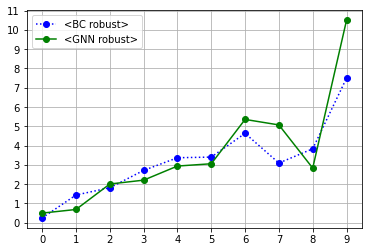

Degree 0: Max(BC robust): 0.50+-0.50; Max(GNN robust): 1.00+-0.00; 
Degree 1: Max(BC robust): 4.00+-0.00; Max(GNN robust): 3.00+-1.00; 
Degree 2: Max(BC robust): 4.00+-0.00; Max(GNN robust): 6.00+-2.00; 
Degree 3: Max(BC robust): 5.50+-0.50; Max(GNN robust): 7.50+-1.50; 
Degree 4: Max(BC robust): 6.50+-0.50; Max(GNN robust): 6.50+-0.50; 
Degree 5: Max(BC robust): 7.50+-1.50; Max(GNN robust): 9.00+-2.00; 
Degree 6: Max(BC robust): 6.50+-0.50; Max(GNN robust): 10.00+-1.00; 
Degree 7: Max(BC robust): 4.50+-1.50; Max(GNN robust): 8.00+-2.00; 
Degree 8: Max(BC robust): 5.00+-1.00; Max(GNN robust): 4.50+-3.50; 
Degree 9: Max(BC robust): 7.50+-0.50; Max(GNN robust): 10.50+-0.50; 
Degree 0: Median(BC robust): 0.25+-0.25; Median(GNN robust): 0.50+-0.00; 
Degree 1: Median(BC robust): 1.00+-0.00; Median(GNN robust): 0.00+-0.00; 
Degree 2: Median(BC robust): 2.00+-0.00; Median(GNN robust): 1.50+-0.50; 
Degree 3: Median(BC robust): 3.00+-0.00; Median(GNN robust): 1.50+-0.50; 
Degree 4: Median(BC ro

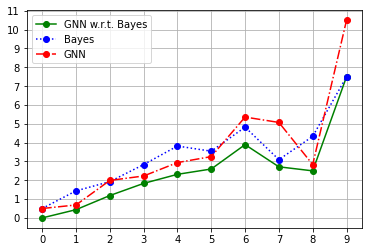

This was K: 1.5.
----------------------------------------------------------


In [6]:
n = 1000
n_iter = 100
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
seed = 1
K_l = [1.5]
attack_method = "l2"
perform_experiments(n, [1,2], n_iter, avg_intra_degree, avg_inter_degree, K_l, attack_method)

## GCN

In [11]:
model_params = dict(
    label="GCN",
    model="DenseGCN", #GCN or DenseGCN
    n_filters=64,
    dropout=0.5
)
train_params = dict(
    loss_type="CE",
    lr=1e-2,
    weight_decay=1e-3,
    patience=300,
    max_epochs=1000,
    use_selftrain = False, 
    use_advtrain = False,
)
attack = "LocalDICEUndirected"
attack_params = dict()

# Other
split_params = {
    "strategy": "normal", # or "custom"
    "p_trn": 1,
    "p_tst": 0, # "normal" uses 1 - p_trn, only for custom split strategy
    "p_selftrn": 0 # Refers to unlabeled data, which is not test data, 
                    # only for custom split strategy
}
verbosity_params = dict(
    display_steps = 1001
)   
# Device
device = 0
if not torch.cuda.is_available():
    device == "cpu", "CUDA is not availble, set device to 'cpu'"
else:
    device = torch.device(f"cuda:{device}")
    logging.info(f"Currently on gpu device {device}")
attack_params["data_device"] = device

INFO:root:Currently on gpu device cuda:0


----------------------------------------------------------
--------------------------K: 0.5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69339, loss_val: 0.69347, acc_train: 0.48800, acc_val: 0.49000
INFO:root:
Epoch  250: loss_train: 0.49040, loss_val: 0.59152, acc_train: 0.76800, acc_val: 0.69400
INFO:root:
Epoch    0: loss_train: 0.69378, loss_val: 0.69444, acc_train: 0.49400, acc_val: 0.42800
INFO:root:
Epoch  648: loss_train: 0.41326, loss_val: 0.51958, acc_train: 0.83800, acc_val: 0.72000
INFO:root:
Epoch    0: loss_train: 0.69266, loss_val: 0.69292, acc_train: 0.55800, acc_val: 0.52000
INFO:root:
Epoch  975: loss_train: 0.42725, loss_val: 0.57678, acc_train: 0.83600, acc_val: 0.72600


Prediction Statistics:
Count BC: 861.3+-9.0; GNN: 685.0+-9.6
Count Structure BC: 855.7+-9.5; Feature BC: 608.7+-9.1
Count BC and GNN: 632.3+-16.6 
Count BC not GNN: 229.0+-10.2; GNN not BC: 52.7+-10.6
Robustness Statistics:
BC more robust than GNN: 194.3+-22.7
BC & GNN equal robustness: 96.0+-5.0
BC less robust than GNN: 342.0+-24.3
Degree 0: <BC robust>: 0.00+-0.00; <GNN robust>: 1.95+-0.61; 
Degree 1: <BC robust>: 0.62+-0.06; <GNN robust>: 1.89+-0.35; 
Degree 2: <BC robust>: 1.16+-0.06; <GNN robust>: 2.78+-0.25; 
Degree 3: <BC robust>: 1.66+-0.10; <GNN robust>: 3.87+-0.30; 
Degree 4: <BC robust>: 2.23+-0.10; <GNN robust>: 3.98+-0.44; 
Degree 5: <BC robust>: 2.63+-0.11; <GNN robust>: 4.65+-0.61; 
Degree 6: <BC robust>: 3.22+-0.08; <GNN robust>: 5.11+-0.54; 
Degree 7: <BC robust>: 3.67+-0.15; <GNN robust>: 6.16+-0.38; 
Degree 8: <BC robust>: 4.05+-0.35; <GNN robust>: 6.54+-1.42; 
Degree 9: <BC robust>: 4.07+-0.64; <GNN robust>: 6.25+-2.39; 
Degree 10: <BC robust>: 4.90+-0.52; <GNN robu

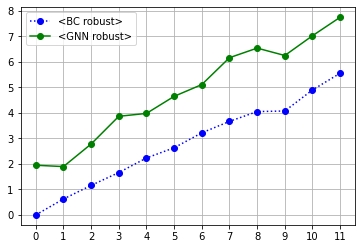

Degree 0: Max(BC robust): 0.00+-0.00; Max(GNN robust): 6.33+-1.70; 
Degree 1: Max(BC robust): 2.00+-0.00; Max(GNN robust): 8.00+-2.16; 
Degree 2: Max(BC robust): 2.67+-0.47; Max(GNN robust): 19.33+-3.40; 
Degree 3: Max(BC robust): 4.00+-0.00; Max(GNN robust): 23.00+-1.63; 
Degree 4: Max(BC robust): 4.67+-0.47; Max(GNN robust): 19.33+-2.05; 
Degree 5: Max(BC robust): 6.00+-0.00; Max(GNN robust): 23.67+-4.50; 
Degree 6: Max(BC robust): 6.33+-0.47; Max(GNN robust): 23.00+-3.56; 
Degree 7: Max(BC robust): 7.33+-0.47; Max(GNN robust): 22.33+-4.99; 
Degree 8: Max(BC robust): 8.33+-0.47; Max(GNN robust): 19.33+-1.25; 
Degree 9: Max(BC robust): 7.33+-0.94; Max(GNN robust): 15.67+-6.34; 
Degree 10: Max(BC robust): 8.33+-0.94; Max(GNN robust): 15.00+-2.83; 
Degree 11: Max(BC robust): 6.33+-3.09; Max(GNN robust): 9.00+-5.00; 
Degree 0: Median(BC robust): 0.00+-0.00; Median(GNN robust): 1.33+-0.47; 
Degree 1: Median(BC robust): 1.00+-0.00; Median(GNN robust): 1.00+-0.00; 
Degree 2: Median(BC robus

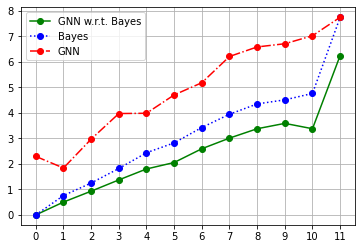

This was K: 0.5.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 1--------------------------


INFO:root:
Epoch    0: loss_train: 0.69351, loss_val: 0.69357, acc_train: 0.48600, acc_val: 0.48800
INFO:root:
Epoch  476: loss_train: 0.38281, loss_val: 0.47217, acc_train: 0.84400, acc_val: 0.77200
INFO:root:
Epoch    0: loss_train: 0.69433, loss_val: 0.69498, acc_train: 0.46600, acc_val: 0.39800
INFO:root:
Epoch  341: loss_train: 0.31744, loss_val: 0.41499, acc_train: 0.88600, acc_val: 0.79400
INFO:root:
Epoch    0: loss_train: 0.69243, loss_val: 0.69270, acc_train: 0.56400, acc_val: 0.52600
INFO:root:
Epoch  975: loss_train: 0.32366, loss_val: 0.44834, acc_train: 0.88800, acc_val: 0.79800


Prediction Statistics:
Count BC: 881.3+-5.6; GNN: 789.3+-4.0
Count Structure BC: 855.7+-9.5; Feature BC: 703.7+-5.2
Count BC and GNN: 752.0+-2.2 
Count BC not GNN: 129.3+-4.9; GNN not BC: 37.3+-4.1
Robustness Statistics:
BC more robust than GNN: 281.3+-12.0
BC & GNN equal robustness: 141.7+-21.3
BC less robust than GNN: 329.0+-34.7
Degree 0: <BC robust>: 0.35+-0.11; <GNN robust>: 1.21+-0.22; 
Degree 1: <BC robust>: 0.95+-0.07; <GNN robust>: 1.54+-0.41; 
Degree 2: <BC robust>: 1.52+-0.07; <GNN robust>: 2.06+-0.10; 
Degree 3: <BC robust>: 1.97+-0.11; <GNN robust>: 2.97+-0.31; 
Degree 4: <BC robust>: 2.49+-0.12; <GNN robust>: 3.17+-0.50; 
Degree 5: <BC robust>: 2.95+-0.06; <GNN robust>: 3.83+-0.62; 
Degree 6: <BC robust>: 3.45+-0.09; <GNN robust>: 4.43+-0.35; 
Degree 7: <BC robust>: 3.99+-0.18; <GNN robust>: 5.42+-0.47; 
Degree 8: <BC robust>: 4.44+-0.41; <GNN robust>: 5.66+-1.12; 
Degree 9: <BC robust>: 4.42+-0.52; <GNN robust>: 6.12+-0.83; 
Degree 10: <BC robust>: 5.07+-0.57; <GNN robus

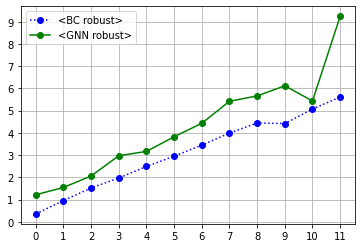

Degree 0: Max(BC robust): 1.00+-0.00; Max(GNN robust): 4.67+-0.47; 
Degree 1: Max(BC robust): 3.00+-0.00; Max(GNN robust): 7.33+-2.05; 
Degree 2: Max(BC robust): 4.00+-0.00; Max(GNN robust): 14.67+-0.47; 
Degree 3: Max(BC robust): 5.00+-0.00; Max(GNN robust): 16.67+-2.36; 
Degree 4: Max(BC robust): 5.67+-0.47; Max(GNN robust): 15.00+-1.41; 
Degree 5: Max(BC robust): 7.00+-0.00; Max(GNN robust): 17.00+-1.63; 
Degree 6: Max(BC robust): 7.33+-0.47; Max(GNN robust): 13.67+-0.94; 
Degree 7: Max(BC robust): 8.33+-0.47; Max(GNN robust): 16.00+-2.94; 
Degree 8: Max(BC robust): 9.33+-0.94; Max(GNN robust): 14.67+-0.94; 
Degree 9: Max(BC robust): 7.67+-0.47; Max(GNN robust): 16.00+-2.83; 
Degree 10: Max(BC robust): 8.00+-0.82; Max(GNN robust): 14.00+-3.27; 
Degree 11: Max(BC robust): 6.67+-3.40; Max(GNN robust): 9.50+-5.50; 
Degree 0: Median(BC robust): 0.17+-0.24; Median(GNN robust): 0.67+-0.47; 
Degree 1: Median(BC robust): 1.00+-0.00; Median(GNN robust): 1.00+-0.00; 
Degree 2: Median(BC robus

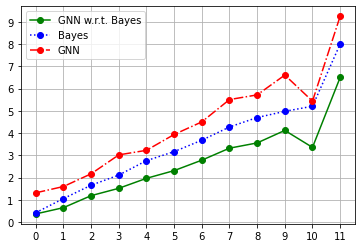

This was K: 1.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 1.5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69364, loss_val: 0.69367, acc_train: 0.47800, acc_val: 0.48400
INFO:root:
Epoch  316: loss_train: 0.29756, loss_val: 0.36635, acc_train: 0.88400, acc_val: 0.84200
INFO:root:
Epoch    0: loss_train: 0.69488, loss_val: 0.69552, acc_train: 0.41400, acc_val: 0.38200
INFO:root:
Epoch  212: loss_train: 0.25940, loss_val: 0.33520, acc_train: 0.90000, acc_val: 0.83200
INFO:root:
Epoch    0: loss_train: 0.69218, loss_val: 0.69248, acc_train: 0.58200, acc_val: 0.55000
INFO:root:
Epoch  562: loss_train: 0.24987, loss_val: 0.35540, acc_train: 0.91400, acc_val: 0.85400


Prediction Statistics:
Count BC: 902.0+-4.2; GNN: 855.0+-7.1
Count Structure BC: 855.7+-9.5; Feature BC: 788.3+-5.0
Count BC and GNN: 822.0+-7.1 
Count BC not GNN: 80.0+-6.7; GNN not BC: 33.0+-0.0
Robustness Statistics:
BC more robust than GNN: 418.7+-28.8
BC & GNN equal robustness: 146.3+-2.4
BC less robust than GNN: 257.0+-32.0
Degree 0: <BC robust>: 0.92+-0.13; <GNN robust>: 0.70+-0.15; 
Degree 1: <BC robust>: 1.59+-0.10; <GNN robust>: 1.23+-0.35; 
Degree 2: <BC robust>: 2.08+-0.07; <GNN robust>: 1.72+-0.17; 
Degree 3: <BC robust>: 2.54+-0.15; <GNN robust>: 2.43+-0.13; 
Degree 4: <BC robust>: 3.03+-0.16; <GNN robust>: 2.72+-0.38; 
Degree 5: <BC robust>: 3.47+-0.03; <GNN robust>: 3.38+-0.30; 
Degree 6: <BC robust>: 3.99+-0.20; <GNN robust>: 4.10+-0.18; 
Degree 7: <BC robust>: 4.51+-0.31; <GNN robust>: 5.03+-0.40; 
Degree 8: <BC robust>: 5.07+-0.53; <GNN robust>: 5.41+-0.81; 
Degree 9: <BC robust>: 5.04+-0.67; <GNN robust>: 5.30+-0.75; 
Degree 10: <BC robust>: 5.59+-0.74; <GNN robust>

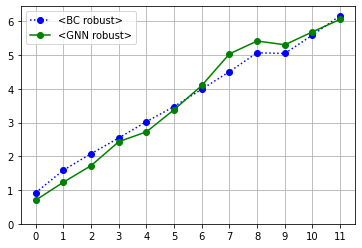

Degree 0: Max(BC robust): 2.67+-0.47; Max(GNN robust): 2.67+-0.47; 
Degree 1: Max(BC robust): 4.67+-0.47; Max(GNN robust): 5.67+-1.70; 
Degree 2: Max(BC robust): 5.33+-0.47; Max(GNN robust): 11.67+-1.25; 
Degree 3: Max(BC robust): 7.00+-0.00; Max(GNN robust): 14.00+-2.94; 
Degree 4: Max(BC robust): 7.00+-0.00; Max(GNN robust): 10.67+-1.25; 
Degree 5: Max(BC robust): 9.00+-0.00; Max(GNN robust): 13.00+-0.82; 
Degree 6: Max(BC robust): 8.33+-0.47; Max(GNN robust): 13.33+-0.47; 
Degree 7: Max(BC robust): 10.00+-0.00; Max(GNN robust): 15.00+-2.83; 
Degree 8: Max(BC robust): 10.67+-1.25; Max(GNN robust): 13.33+-0.47; 
Degree 9: Max(BC robust): 8.67+-0.47; Max(GNN robust): 13.00+-2.94; 
Degree 10: Max(BC robust): 8.33+-0.47; Max(GNN robust): 10.33+-1.25; 
Degree 11: Max(BC robust): 7.33+-3.86; Max(GNN robust): 6.67+-6.02; 
Degree 0: Median(BC robust): 0.50+-0.41; Median(GNN robust): 0.17+-0.24; 
Degree 1: Median(BC robust): 1.33+-0.47; Median(GNN robust): 0.67+-0.47; 
Degree 2: Median(BC rob

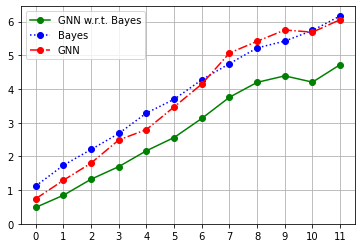

This was K: 1.5.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 2--------------------------


INFO:root:
Epoch    0: loss_train: 0.69377, loss_val: 0.69376, acc_train: 0.45800, acc_val: 0.46800
INFO:root:
Epoch  316: loss_train: 0.24372, loss_val: 0.29942, acc_train: 0.90400, acc_val: 0.87800
INFO:root:
Epoch    0: loss_train: 0.69543, loss_val: 0.69605, acc_train: 0.38800, acc_val: 0.34600
INFO:root:
Epoch  493: loss_train: 0.20494, loss_val: 0.27556, acc_train: 0.92400, acc_val: 0.89000
INFO:root:
Epoch    0: loss_train: 0.69192, loss_val: 0.69225, acc_train: 0.59800, acc_val: 0.56600
INFO:root:
Epoch   52: loss_train: 0.23086, loss_val: 0.28917, acc_train: 0.92200, acc_val: 0.88800


Prediction Statistics:
Count BC: 931.0+-1.6; GNN: 883.7+-1.2
Count Structure BC: 855.7+-9.5; Feature BC: 846.3+-6.9
Count BC and GNN: 863.3+-2.4 
Count BC not GNN: 67.7+-1.2; GNN not BC: 20.3+-2.9
Robustness Statistics:
BC more robust than GNN: 565.3+-29.8
BC & GNN equal robustness: 135.7+-14.7
BC less robust than GNN: 162.3+-21.3
Degree 0: <BC robust>: 1.70+-0.14; <GNN robust>: 0.46+-0.07; 
Degree 1: <BC robust>: 2.27+-0.13; <GNN robust>: 1.13+-0.35; 
Degree 2: <BC robust>: 2.80+-0.11; <GNN robust>: 1.53+-0.10; 
Degree 3: <BC robust>: 3.28+-0.15; <GNN robust>: 2.21+-0.12; 
Degree 4: <BC robust>: 3.73+-0.14; <GNN robust>: 2.58+-0.39; 
Degree 5: <BC robust>: 4.19+-0.06; <GNN robust>: 3.25+-0.16; 
Degree 6: <BC robust>: 4.74+-0.15; <GNN robust>: 3.97+-0.18; 
Degree 7: <BC robust>: 5.27+-0.34; <GNN robust>: 4.60+-0.29; 
Degree 8: <BC robust>: 5.98+-0.65; <GNN robust>: 5.18+-0.67; 
Degree 9: <BC robust>: 5.57+-0.21; <GNN robust>: 5.18+-0.60; 
Degree 10: <BC robust>: 6.19+-0.86; <GNN robust

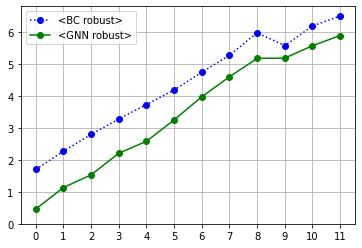

Degree 0: Max(BC robust): 4.00+-0.00; Max(GNN robust): 2.33+-0.47; 
Degree 1: Max(BC robust): 6.33+-0.47; Max(GNN robust): 6.00+-2.16; 
Degree 2: Max(BC robust): 7.33+-0.47; Max(GNN robust): 8.67+-1.25; 
Degree 3: Max(BC robust): 8.67+-0.47; Max(GNN robust): 11.00+-1.63; 
Degree 4: Max(BC robust): 8.67+-0.47; Max(GNN robust): 10.33+-1.25; 
Degree 5: Max(BC robust): 10.67+-0.47; Max(GNN robust): 10.67+-1.25; 
Degree 6: Max(BC robust): 10.00+-0.82; Max(GNN robust): 11.67+-0.94; 
Degree 7: Max(BC robust): 11.33+-0.47; Max(GNN robust): 14.00+-2.94; 
Degree 8: Max(BC robust): 12.00+-1.41; Max(GNN robust): 12.33+-0.94; 
Degree 9: Max(BC robust): 9.67+-0.94; Max(GNN robust): 11.33+-2.05; 
Degree 10: Max(BC robust): 9.33+-0.94; Max(GNN robust): 9.33+-1.70; 
Degree 11: Max(BC robust): 7.67+-4.19; Max(GNN robust): 6.67+-2.87; 
Degree 0: Median(BC robust): 1.50+-0.41; Median(GNN robust): 0.00+-0.00; 
Degree 1: Median(BC robust): 2.00+-0.00; Median(GNN robust): 0.67+-0.47; 
Degree 2: Median(BC rob

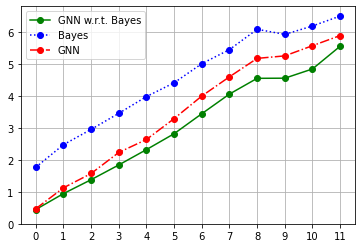

This was K: 2.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69469, loss_val: 0.69451, acc_train: 0.40800, acc_val: 0.42000
INFO:root:
Epoch  468: loss_train: 0.13992, loss_val: 0.17911, acc_train: 0.95000, acc_val: 0.92200
INFO:root:
Epoch    0: loss_train: 0.69868, loss_val: 0.69932, acc_train: 0.26400, acc_val: 0.19200
INFO:root:
Epoch   53: loss_train: 0.12871, loss_val: 0.16920, acc_train: 0.95400, acc_val: 0.92400
INFO:root:
Epoch    0: loss_train: 0.69032, loss_val: 0.69083, acc_train: 0.63000, acc_val: 0.59400
INFO:root:
Epoch   48: loss_train: 0.13872, loss_val: 0.17293, acc_train: 0.94000, acc_val: 0.93400


Prediction Statistics:
Count BC: 996.7+-2.6; GNN: 926.3+-1.7
Count Structure BC: 855.7+-9.5; Feature BC: 995.0+-0.0
Count BC and GNN: 925.7+-1.2 
Count BC not GNN: 71.0+-2.9; GNN not BC: 0.7+-0.5
Robustness Statistics:
BC more robust than GNN: 917.3+-4.1
BC & GNN equal robustness: 4.7+-1.2
BC less robust than GNN: 3.7+-2.5
Degree 0: <BC robust>: 10.52+-0.45; <GNN robust>: 0.18+-0.11; 
Degree 1: <BC robust>: 11.39+-0.28; <GNN robust>: 0.88+-0.24; 
Degree 2: <BC robust>: 12.00+-0.31; <GNN robust>: 1.47+-0.10; 
Degree 3: <BC robust>: 12.43+-0.05; <GNN robust>: 2.16+-0.19; 
Degree 4: <BC robust>: 12.85+-0.24; <GNN robust>: 2.71+-0.28; 
Degree 5: <BC robust>: 13.58+-0.07; <GNN robust>: 3.34+-0.15; 
Degree 6: <BC robust>: 14.07+-0.49; <GNN robust>: 4.09+-0.31; 
Degree 7: <BC robust>: 14.36+-0.94; <GNN robust>: 4.70+-0.26; 
Degree 8: <BC robust>: 15.84+-0.86; <GNN robust>: 5.23+-0.41; 
Degree 9: <BC robust>: 15.10+-0.15; <GNN robust>: 5.54+-0.60; 
Degree 10: <BC robust>: 15.21+-2.19; <GNN rob

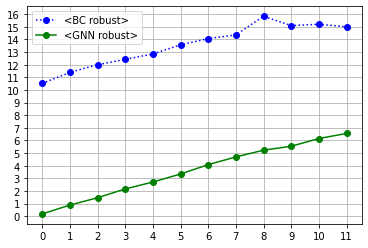

Degree 0: Max(BC robust): 17.67+-0.94; Max(GNN robust): 1.00+-0.00; 
Degree 1: Max(BC robust): 22.33+-1.25; Max(GNN robust): 3.33+-0.94; 
Degree 2: Max(BC robust): 23.00+-0.82; Max(GNN robust): 5.33+-0.47; 
Degree 3: Max(BC robust): 25.00+-0.82; Max(GNN robust): 8.00+-0.82; 
Degree 4: Max(BC robust): 23.67+-1.25; Max(GNN robust): 8.00+-0.82; 
Degree 5: Max(BC robust): 27.00+-0.82; Max(GNN robust): 10.67+-0.94; 
Degree 6: Max(BC robust): 24.00+-0.82; Max(GNN robust): 11.33+-0.47; 
Degree 7: Max(BC robust): 25.67+-0.47; Max(GNN robust): 13.00+-1.41; 
Degree 8: Max(BC robust): 26.33+-2.36; Max(GNN robust): 11.67+-1.70; 
Degree 9: Max(BC robust): 23.00+-1.41; Max(GNN robust): 11.00+-1.63; 
Degree 10: Max(BC robust): 21.00+-4.32; Max(GNN robust): 9.00+-2.16; 
Degree 11: Max(BC robust): 17.00+-6.53; Max(GNN robust): 7.67+-3.40; 
Degree 0: Median(BC robust): 9.83+-0.85; Median(GNN robust): 0.00+-0.00; 
Degree 1: Median(BC robust): 11.67+-0.47; Median(GNN robust): 0.67+-0.47; 
Degree 2: Median

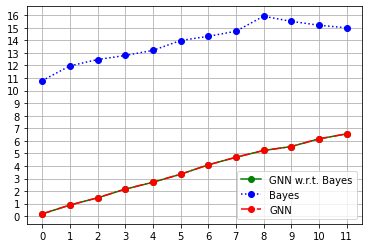

This was K: 5.
----------------------------------------------------------


In [7]:
n = 1000
n_iter = 1000
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
seed_l = [1, 2, 3]
K_l = [0.5, 1, 1.5, 2, 5]
attack_method = "l2"
perform_experiments(n, seed_l, n_iter, avg_intra_degree, avg_inter_degree, K_l, attack_method)

----------------------------------------------------------
--------------------------K: 0.5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69339, loss_val: 0.69347, acc_train: 0.48800, acc_val: 0.49000
INFO:root:
Epoch  250: loss_train: 0.49040, loss_val: 0.59152, acc_train: 0.76800, acc_val: 0.69400
INFO:root:
Epoch    0: loss_train: 0.69378, loss_val: 0.69444, acc_train: 0.49400, acc_val: 0.42800
INFO:root:
Epoch  648: loss_train: 0.41326, loss_val: 0.51958, acc_train: 0.83800, acc_val: 0.72000
INFO:root:
Epoch    0: loss_train: 0.69266, loss_val: 0.69292, acc_train: 0.55800, acc_val: 0.52000
INFO:root:
Epoch  975: loss_train: 0.42725, loss_val: 0.57678, acc_train: 0.83600, acc_val: 0.72600


Prediction Statistics:
Count BC: 849.7+-3.1; GNN: 679.3+-19.1
Count Structure BC: 838.0+-10.2; Feature BC: 602.3+-10.1
Count BC and GNN: 622.3+-22.3 
Count BC not GNN: 227.3+-21.6; GNN not BC: 57.0+-3.3
Robustness Statistics:
BC more robust than GNN: 142.3+-13.8
BC & GNN equal robustness: 58.3+-7.0
BC less robust than GNN: 421.7+-11.4
Degree 0: <BC robust>: 0.09+-0.03; <GNN robust>: 6.49+-3.97; 
Degree 1: <BC robust>: 0.67+-0.07; <GNN robust>: 8.01+-1.38; 
Degree 2: <BC robust>: 1.14+-0.05; <GNN robust>: 6.35+-2.14; 
Degree 3: <BC robust>: 1.64+-0.04; <GNN robust>: 8.14+-0.79; 
Degree 4: <BC robust>: 2.16+-0.06; <GNN robust>: 9.20+-1.37; 
Degree 5: <BC robust>: 2.59+-0.04; <GNN robust>: 9.63+-1.54; 
Degree 6: <BC robust>: 3.04+-0.17; <GNN robust>: 10.34+-1.49; 
Degree 7: <BC robust>: 3.54+-0.14; <GNN robust>: 10.72+-1.31; 
Degree 8: <BC robust>: 4.42+-0.24; <GNN robust>: 11.42+-3.25; 
Degree 9: <BC robust>: 4.87+-0.27; <GNN robust>: 13.88+-6.83; 
Degree 10: <BC robust>: 4.70+-0.15; <GN

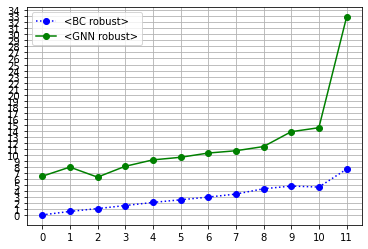

Degree 0: Max(BC robust): 1.00+-0.00; Max(GNN robust): 32.00+-15.12; 
Degree 1: Max(BC robust): 2.00+-0.00; Max(GNN robust): 57.67+-16.21; 
Degree 2: Max(BC robust): 2.67+-0.47; Max(GNN robust): 54.00+-12.03; 
Degree 3: Max(BC robust): 4.00+-0.00; Max(GNN robust): 94.00+-14.17; 
Degree 4: Max(BC robust): 5.00+-0.00; Max(GNN robust): 62.33+-18.93; 
Degree 5: Max(BC robust): 6.00+-0.00; Max(GNN robust): 72.00+-19.82; 
Degree 6: Max(BC robust): 6.33+-0.47; Max(GNN robust): 60.00+-19.51; 
Degree 7: Max(BC robust): 7.33+-0.47; Max(GNN robust): 53.67+-5.31; 
Degree 8: Max(BC robust): 8.00+-0.00; Max(GNN robust): 42.67+-18.62; 
Degree 9: Max(BC robust): 8.67+-1.25; Max(GNN robust): 48.33+-33.69; 
Degree 10: Max(BC robust): 8.00+-1.63; Max(GNN robust): 28.33+-2.87; 
Degree 11: Max(BC robust): 9.00+-1.63; Max(GNN robust): 48.67+-22.23; 
Degree 0: Median(BC robust): 0.00+-0.00; Median(GNN robust): 1.00+-0.82; 
Degree 1: Median(BC robust): 1.00+-0.00; Median(GNN robust): 3.33+-0.94; 
Degree 2: Me

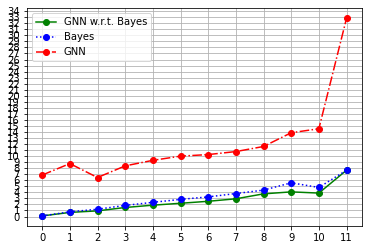

This was K: 0.5.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 1--------------------------


INFO:root:
Epoch    0: loss_train: 0.69351, loss_val: 0.69357, acc_train: 0.48600, acc_val: 0.48800
INFO:root:
Epoch  476: loss_train: 0.38281, loss_val: 0.47217, acc_train: 0.84400, acc_val: 0.77200
INFO:root:
Epoch    0: loss_train: 0.69433, loss_val: 0.69498, acc_train: 0.46600, acc_val: 0.39800
INFO:root:
Epoch  341: loss_train: 0.31744, loss_val: 0.41499, acc_train: 0.88600, acc_val: 0.79400
INFO:root:
Epoch    0: loss_train: 0.69243, loss_val: 0.69270, acc_train: 0.56400, acc_val: 0.52600
INFO:root:
Epoch  975: loss_train: 0.32366, loss_val: 0.44834, acc_train: 0.88800, acc_val: 0.79800


Prediction Statistics:
Count BC: 871.0+-2.2; GNN: 779.0+-12.8
Count Structure BC: 838.0+-10.2; Feature BC: 694.0+-12.7
Count BC and GNN: 736.0+-14.2 
Count BC not GNN: 135.0+-13.0; GNN not BC: 43.0+-1.6
Robustness Statistics:
BC more robust than GNN: 177.0+-8.5
BC & GNN equal robustness: 79.3+-5.4
BC less robust than GNN: 479.7+-5.9
Degree 0: <BC robust>: 0.57+-0.13; <GNN robust>: 3.12+-1.21; 
Degree 1: <BC robust>: 1.14+-0.05; <GNN robust>: 4.98+-0.20; 
Degree 2: <BC robust>: 1.47+-0.03; <GNN robust>: 4.36+-0.89; 
Degree 3: <BC robust>: 1.93+-0.06; <GNN robust>: 5.88+-0.53; 
Degree 4: <BC robust>: 2.44+-0.10; <GNN robust>: 6.59+-0.43; 
Degree 5: <BC robust>: 2.92+-0.05; <GNN robust>: 7.42+-0.86; 
Degree 6: <BC robust>: 3.30+-0.24; <GNN robust>: 8.12+-1.06; 
Degree 7: <BC robust>: 3.87+-0.18; <GNN robust>: 8.35+-0.66; 
Degree 8: <BC robust>: 4.80+-0.18; <GNN robust>: 9.26+-0.95; 
Degree 9: <BC robust>: 5.17+-0.41; <GNN robust>: 9.64+-2.80; 
Degree 10: <BC robust>: 5.30+-0.33; <GNN robu

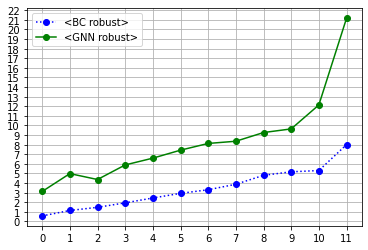

Degree 0: Max(BC robust): 2.33+-0.47; Max(GNN robust): 15.67+-7.41; 
Degree 1: Max(BC robust): 3.33+-0.47; Max(GNN robust): 31.00+-10.61; 
Degree 2: Max(BC robust): 3.67+-0.47; Max(GNN robust): 37.00+-8.29; 
Degree 3: Max(BC robust): 5.33+-0.47; Max(GNN robust): 61.33+-12.55; 
Degree 4: Max(BC robust): 6.33+-0.47; Max(GNN robust): 39.33+-3.77; 
Degree 5: Max(BC robust): 7.33+-0.47; Max(GNN robust): 45.67+-9.46; 
Degree 6: Max(BC robust): 7.33+-0.47; Max(GNN robust): 37.33+-8.99; 
Degree 7: Max(BC robust): 8.67+-0.47; Max(GNN robust): 39.33+-5.44; 
Degree 8: Max(BC robust): 8.67+-0.47; Max(GNN robust): 28.00+-3.27; 
Degree 9: Max(BC robust): 9.00+-1.63; Max(GNN robust): 26.00+-14.31; 
Degree 10: Max(BC robust): 9.00+-1.63; Max(GNN robust): 24.00+-6.53; 
Degree 11: Max(BC robust): 9.00+-1.63; Max(GNN robust): 30.00+-14.31; 
Degree 0: Median(BC robust): 0.33+-0.47; Median(GNN robust): 1.33+-0.47; 
Degree 1: Median(BC robust): 1.00+-0.00; Median(GNN robust): 2.67+-0.47; 
Degree 2: Median(B

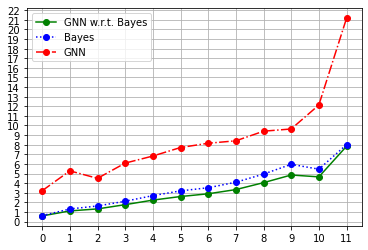

This was K: 1.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 1.5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69364, loss_val: 0.69367, acc_train: 0.47800, acc_val: 0.48400
INFO:root:
Epoch  316: loss_train: 0.29756, loss_val: 0.36635, acc_train: 0.88400, acc_val: 0.84200
INFO:root:
Epoch    0: loss_train: 0.69488, loss_val: 0.69552, acc_train: 0.41400, acc_val: 0.38200
INFO:root:
Epoch  212: loss_train: 0.25940, loss_val: 0.33520, acc_train: 0.90000, acc_val: 0.83200
INFO:root:
Epoch    0: loss_train: 0.69218, loss_val: 0.69248, acc_train: 0.58200, acc_val: 0.55000
INFO:root:
Epoch  562: loss_train: 0.24987, loss_val: 0.35540, acc_train: 0.91400, acc_val: 0.85400


Prediction Statistics:
Count BC: 900.7+-2.1; GNN: 841.3+-3.3
Count Structure BC: 838.0+-10.2; Feature BC: 783.7+-17.2
Count BC and GNN: 810.3+-0.5 
Count BC not GNN: 90.3+-2.5; GNN not BC: 31.0+-3.3
Robustness Statistics:
BC more robust than GNN: 212.0+-3.3
BC & GNN equal robustness: 115.0+-13.6
BC less robust than GNN: 483.3+-16.2
Degree 0: <BC robust>: 1.38+-0.11; <GNN robust>: 2.10+-0.63; 
Degree 1: <BC robust>: 1.73+-0.07; <GNN robust>: 3.97+-0.10; 
Degree 2: <BC robust>: 1.94+-0.07; <GNN robust>: 3.59+-0.53; 
Degree 3: <BC robust>: 2.52+-0.12; <GNN robust>: 4.64+-0.34; 
Degree 4: <BC robust>: 2.90+-0.13; <GNN robust>: 5.46+-0.19; 
Degree 5: <BC robust>: 3.43+-0.07; <GNN robust>: 6.29+-0.41; 
Degree 6: <BC robust>: 3.84+-0.20; <GNN robust>: 7.07+-0.64; 
Degree 7: <BC robust>: 4.33+-0.24; <GNN robust>: 7.60+-0.20; 
Degree 8: <BC robust>: 5.49+-0.08; <GNN robust>: 8.28+-0.39; 
Degree 9: <BC robust>: 6.00+-0.32; <GNN robust>: 9.43+-2.44; 
Degree 10: <BC robust>: 6.30+-0.33; <GNN robus

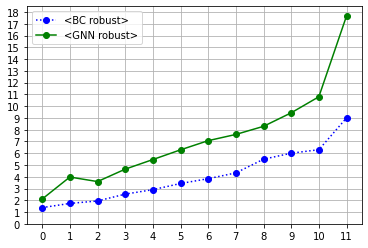

Degree 0: Max(BC robust): 3.67+-0.94; Max(GNN robust): 10.67+-3.40; 
Degree 1: Max(BC robust): 5.33+-0.47; Max(GNN robust): 22.00+-6.38; 
Degree 2: Max(BC robust): 5.00+-0.82; Max(GNN robust): 20.67+-3.77; 
Degree 3: Max(BC robust): 6.67+-0.94; Max(GNN robust): 36.33+-9.74; 
Degree 4: Max(BC robust): 7.67+-0.47; Max(GNN robust): 26.00+-2.83; 
Degree 5: Max(BC robust): 9.33+-0.47; Max(GNN robust): 29.67+-6.24; 
Degree 6: Max(BC robust): 8.67+-0.47; Max(GNN robust): 30.00+-2.45; 
Degree 7: Max(BC robust): 9.67+-0.47; Max(GNN robust): 31.33+-6.94; 
Degree 8: Max(BC robust): 9.67+-0.47; Max(GNN robust): 23.00+-1.41; 
Degree 9: Max(BC robust): 10.33+-1.89; Max(GNN robust): 23.00+-11.52; 
Degree 10: Max(BC robust): 10.33+-1.25; Max(GNN robust): 22.33+-5.31; 
Degree 11: Max(BC robust): 10.00+-1.63; Max(GNN robust): 23.00+-11.43; 
Degree 0: Median(BC robust): 1.00+-0.00; Median(GNN robust): 1.00+-0.00; 
Degree 1: Median(BC robust): 1.67+-0.47; Median(GNN robust): 3.00+-0.00; 
Degree 2: Median(

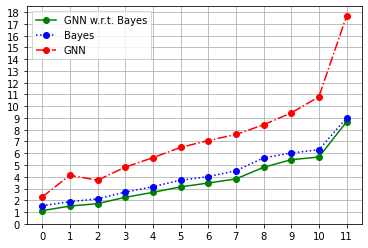

This was K: 1.5.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 2--------------------------


INFO:root:
Epoch    0: loss_train: 0.69377, loss_val: 0.69376, acc_train: 0.45800, acc_val: 0.46800
INFO:root:
Epoch  316: loss_train: 0.24372, loss_val: 0.29942, acc_train: 0.90400, acc_val: 0.87800
INFO:root:
Epoch    0: loss_train: 0.69543, loss_val: 0.69605, acc_train: 0.38800, acc_val: 0.34600
INFO:root:
Epoch  493: loss_train: 0.20494, loss_val: 0.27556, acc_train: 0.92400, acc_val: 0.89000
INFO:root:
Epoch    0: loss_train: 0.69192, loss_val: 0.69225, acc_train: 0.59800, acc_val: 0.56600
INFO:root:
Epoch   52: loss_train: 0.23086, loss_val: 0.28917, acc_train: 0.92200, acc_val: 0.88800


Prediction Statistics:
Count BC: 924.7+-1.2; GNN: 878.3+-6.6
Count Structure BC: 838.0+-10.2; Feature BC: 845.7+-10.2
Count BC and GNN: 857.3+-5.7 
Count BC not GNN: 67.3+-6.3; GNN not BC: 21.0+-1.6
Robustness Statistics:
BC more robust than GNN: 319.7+-18.7
BC & GNN equal robustness: 129.3+-5.3
BC less robust than GNN: 408.3+-20.0
Degree 0: <BC robust>: 2.13+-0.24; <GNN robust>: 1.65+-0.46; 
Degree 1: <BC robust>: 2.55+-0.20; <GNN robust>: 3.25+-0.13; 
Degree 2: <BC robust>: 2.71+-0.06; <GNN robust>: 3.17+-0.38; 
Degree 3: <BC robust>: 3.28+-0.15; <GNN robust>: 4.05+-0.23; 
Degree 4: <BC robust>: 3.64+-0.19; <GNN robust>: 4.78+-0.27; 
Degree 5: <BC robust>: 4.16+-0.06; <GNN robust>: 5.60+-0.32; 
Degree 6: <BC robust>: 4.57+-0.20; <GNN robust>: 6.31+-0.40; 
Degree 7: <BC robust>: 5.06+-0.29; <GNN robust>: 6.95+-0.18; 
Degree 8: <BC robust>: 6.33+-0.15; <GNN robust>: 7.81+-0.21; 
Degree 9: <BC robust>: 6.68+-0.62; <GNN robust>: 8.36+-1.25; 
Degree 10: <BC robust>: 7.13+-0.51; <GNN robus

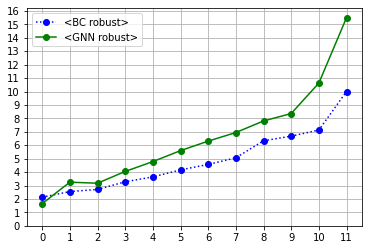

Degree 0: Max(BC robust): 5.67+-0.94; Max(GNN robust): 7.00+-3.56; 
Degree 1: Max(BC robust): 7.33+-0.47; Max(GNN robust): 18.67+-5.19; 
Degree 2: Max(BC robust): 7.00+-0.82; Max(GNN robust): 18.67+-1.70; 
Degree 3: Max(BC robust): 8.67+-0.94; Max(GNN robust): 19.00+-2.83; 
Degree 4: Max(BC robust): 9.67+-0.94; Max(GNN robust): 20.67+-3.68; 
Degree 5: Max(BC robust): 11.33+-0.47; Max(GNN robust): 24.33+-4.03; 
Degree 6: Max(BC robust): 10.00+-0.00; Max(GNN robust): 25.00+-1.63; 
Degree 7: Max(BC robust): 11.00+-0.82; Max(GNN robust): 27.00+-7.07; 
Degree 8: Max(BC robust): 11.33+-0.94; Max(GNN robust): 19.67+-0.47; 
Degree 9: Max(BC robust): 11.67+-2.36; Max(GNN robust): 18.33+-7.93; 
Degree 10: Max(BC robust): 11.33+-1.25; Max(GNN robust): 18.67+-2.62; 
Degree 11: Max(BC robust): 11.00+-1.63; Max(GNN robust): 20.00+-6.48; 
Degree 0: Median(BC robust): 2.00+-0.00; Median(GNN robust): 1.00+-0.00; 
Degree 1: Median(BC robust): 2.67+-0.47; Median(GNN robust): 2.00+-0.00; 
Degree 2: Median

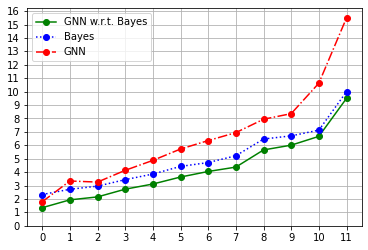

This was K: 2.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69469, loss_val: 0.69451, acc_train: 0.40800, acc_val: 0.42000
INFO:root:
Epoch  468: loss_train: 0.13992, loss_val: 0.17911, acc_train: 0.95000, acc_val: 0.92200
INFO:root:
Epoch    0: loss_train: 0.69868, loss_val: 0.69932, acc_train: 0.26400, acc_val: 0.19200
INFO:root:
Epoch   53: loss_train: 0.12871, loss_val: 0.16920, acc_train: 0.95400, acc_val: 0.92400
INFO:root:
Epoch    0: loss_train: 0.69032, loss_val: 0.69083, acc_train: 0.63000, acc_val: 0.59400
INFO:root:
Epoch   48: loss_train: 0.13872, loss_val: 0.17293, acc_train: 0.94000, acc_val: 0.93400


Prediction Statistics:
Count BC: 996.7+-0.5; GNN: 933.3+-1.9
Count Structure BC: 838.0+-10.2; Feature BC: 993.3+-2.1
Count BC and GNN: 932.0+-2.2 
Count BC not GNN: 64.7+-1.9; GNN not BC: 1.3+-0.5
Robustness Statistics:
BC more robust than GNN: 916.3+-4.0
BC & GNN equal robustness: 6.7+-0.5
BC less robust than GNN: 9.0+-1.4
Degree 0: <BC robust>: 11.44+-0.30; <GNN robust>: 0.88+-0.18; 
Degree 1: <BC robust>: 12.31+-0.63; <GNN robust>: 1.93+-0.15; 
Degree 2: <BC robust>: 11.80+-0.24; <GNN robust>: 2.52+-0.15; 
Degree 3: <BC robust>: 12.51+-0.28; <GNN robust>: 3.21+-0.16; 
Degree 4: <BC robust>: 12.73+-0.65; <GNN robust>: 4.12+-0.06; 
Degree 5: <BC robust>: 13.50+-0.35; <GNN robust>: 4.74+-0.25; 
Degree 6: <BC robust>: 13.70+-0.31; <GNN robust>: 5.59+-0.24; 
Degree 7: <BC robust>: 14.15+-0.51; <GNN robust>: 6.31+-0.35; 
Degree 8: <BC robust>: 15.69+-0.79; <GNN robust>: 7.27+-0.25; 
Degree 9: <BC robust>: 16.28+-1.59; <GNN robust>: 8.02+-0.70; 
Degree 10: <BC robust>: 17.79+-1.43; <GNN ro

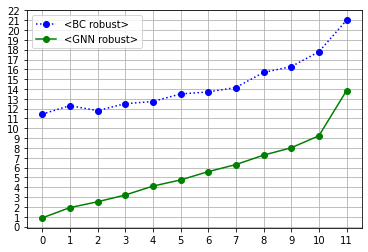

Degree 0: Max(BC robust): 21.00+-2.16; Max(GNN robust): 2.67+-0.47; 
Degree 1: Max(BC robust): 24.00+-1.41; Max(GNN robust): 8.67+-1.70; 
Degree 2: Max(BC robust): 22.67+-1.70; Max(GNN robust): 11.00+-0.82; 
Degree 3: Max(BC robust): 24.67+-2.36; Max(GNN robust): 12.00+-0.82; 
Degree 4: Max(BC robust): 26.00+-1.41; Max(GNN robust): 14.00+-2.16; 
Degree 5: Max(BC robust): 27.67+-0.94; Max(GNN robust): 14.00+-0.82; 
Degree 6: Max(BC robust): 24.00+-0.82; Max(GNN robust): 14.67+-0.94; 
Degree 7: Max(BC robust): 25.33+-1.25; Max(GNN robust): 18.00+-2.45; 
Degree 8: Max(BC robust): 25.67+-1.70; Max(GNN robust): 15.67+-2.05; 
Degree 9: Max(BC robust): 26.67+-3.86; Max(GNN robust): 14.67+-3.40; 
Degree 10: Max(BC robust): 24.33+-1.25; Max(GNN robust): 13.33+-1.25; 
Degree 11: Max(BC robust): 21.67+-1.70; Max(GNN robust): 16.67+-1.25; 
Degree 0: Median(BC robust): 11.33+-0.94; Median(GNN robust): 0.83+-0.24; 
Degree 1: Median(BC robust): 12.33+-0.94; Median(GNN robust): 2.00+-0.00; 
Degree 2: 

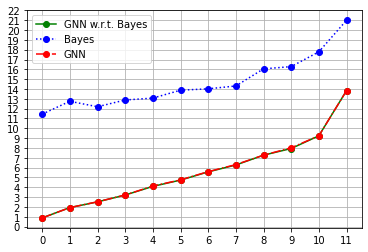

This was K: 5.
----------------------------------------------------------


In [12]:
n = 1000
n_iter = 1000
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
seed_l = [1, 2, 3]
K_l = [0.5, 1, 1.5, 2, 5]
attack_method = "random"
perform_experiments(n, seed_l, n_iter, avg_intra_degree, avg_inter_degree, K_l, attack_method)

# APPNP

In [8]:
model_params = dict(
    label="APPNP",
    model="APPNP", #GCN or DenseGCN
    n_hidden=64,
    dropout=0.,
    K=10,
    alpha=0.1
)
train_params = dict(
    loss_type="CE",
    lr=1e-2,
    weight_decay=1e-3,
    patience=300,
    max_epochs=1000,
    use_selftrain = False, 
    use_advtrain = False,
)

# Other
split_params = {
    "strategy": "normal", # or "custom"
    "p_trn": 1,
    "p_tst": 0, # "normal" uses 1 - p_trn, only for custom split strategy
    "p_selftrn": 0 # Refers to unlabeled data, which is not test data, 
                    # only for custom split strategy
}
verbosity_params = dict(
    display_steps = 1001
)   
# Device
device = 0
if not torch.cuda.is_available():
    device == "cpu", "CUDA is not availble, set device to 'cpu'"
else:
    device = torch.device(f"cuda:{device}")
    logging.info(f"Currently on gpu device {device}")
attack_params["data_device"] = device

INFO:root:Currently on gpu device cuda:0


----------------------------------------------------------
--------------------------K: 0.5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69477, loss_val: 0.69559, acc_train: 0.47800, acc_val: 0.47800
INFO:root:
Epoch  993: loss_train: 0.48823, loss_val: 0.60483, acc_train: 0.81200, acc_val: 0.68800
INFO:root:
Epoch    0: loss_train: 0.69435, loss_val: 0.69544, acc_train: 0.50400, acc_val: 0.50400
INFO:root:
Epoch  271: loss_train: 0.44233, loss_val: 0.55136, acc_train: 0.80000, acc_val: 0.70800
INFO:root:
Epoch    0: loss_train: 0.69168, loss_val: 0.69187, acc_train: 0.52400, acc_val: 0.52400
INFO:root:
Epoch  935: loss_train: 0.45874, loss_val: 0.58513, acc_train: 0.82000, acc_val: 0.71200


Prediction Statistics:
Count BC: 861.3+-9.0; GNN: 682.3+-5.7
Count Structure BC: 855.7+-9.5; Feature BC: 608.7+-9.1
Count BC and GNN: 629.3+-14.1 
Count BC not GNN: 232.0+-5.7; GNN not BC: 53.0+-8.6
Robustness Statistics:
BC more robust than GNN: 147.0+-13.4
BC & GNN equal robustness: 82.3+-8.3
BC less robust than GNN: 400.0+-12.2
Degree 0: <BC robust>: 0.00+-0.00; <GNN robust>: 2.14+-0.62; 
Degree 1: <BC robust>: 0.62+-0.06; <GNN robust>: 2.60+-0.33; 
Degree 2: <BC robust>: 1.16+-0.06; <GNN robust>: 4.45+-0.69; 
Degree 3: <BC robust>: 1.66+-0.10; <GNN robust>: 5.07+-0.69; 
Degree 4: <BC robust>: 2.23+-0.10; <GNN robust>: 4.97+-0.63; 
Degree 5: <BC robust>: 2.63+-0.11; <GNN robust>: 5.65+-0.46; 
Degree 6: <BC robust>: 3.22+-0.08; <GNN robust>: 6.27+-1.00; 
Degree 7: <BC robust>: 3.67+-0.15; <GNN robust>: 7.28+-0.66; 
Degree 8: <BC robust>: 4.05+-0.35; <GNN robust>: 6.60+-0.54; 
Degree 9: <BC robust>: 4.07+-0.64; <GNN robust>: 7.00+-1.44; 
Degree 10: <BC robust>: 4.90+-0.52; <GNN robust

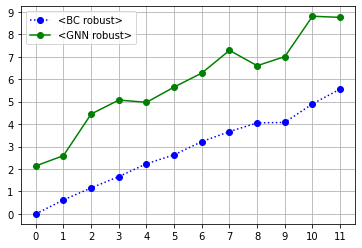

Degree 0: Max(BC robust): 0.00+-0.00; Max(GNN robust): 5.33+-2.36; 
Degree 1: Max(BC robust): 2.00+-0.00; Max(GNN robust): 10.67+-1.89; 
Degree 2: Max(BC robust): 2.67+-0.47; Max(GNN robust): 25.33+-6.02; 
Degree 3: Max(BC robust): 4.00+-0.00; Max(GNN robust): 27.33+-9.88; 
Degree 4: Max(BC robust): 4.67+-0.47; Max(GNN robust): 26.67+-10.27; 
Degree 5: Max(BC robust): 6.00+-0.00; Max(GNN robust): 25.67+-6.13; 
Degree 6: Max(BC robust): 6.33+-0.47; Max(GNN robust): 23.33+-3.09; 
Degree 7: Max(BC robust): 7.33+-0.47; Max(GNN robust): 21.00+-2.83; 
Degree 8: Max(BC robust): 8.33+-0.47; Max(GNN robust): 20.67+-3.30; 
Degree 9: Max(BC robust): 7.33+-0.94; Max(GNN robust): 17.33+-2.49; 
Degree 10: Max(BC robust): 8.33+-0.94; Max(GNN robust): 16.00+-5.10; 
Degree 11: Max(BC robust): 6.33+-3.09; Max(GNN robust): 9.00+-3.00; 
Degree 0: Median(BC robust): 0.00+-0.00; Median(GNN robust): 1.67+-0.47; 
Degree 1: Median(BC robust): 1.00+-0.00; Median(GNN robust): 1.50+-0.41; 
Degree 2: Median(BC rob

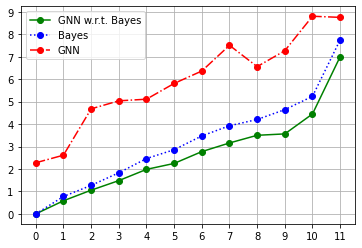

This was K: 0.5.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 1--------------------------


INFO:root:
Epoch    0: loss_train: 0.69422, loss_val: 0.69507, acc_train: 0.47800, acc_val: 0.47800
INFO:root:
Epoch  953: loss_train: 0.42839, loss_val: 0.48593, acc_train: 0.81200, acc_val: 0.77200
INFO:root:
Epoch    0: loss_train: 0.69418, loss_val: 0.69528, acc_train: 0.50400, acc_val: 0.50400
INFO:root:
Epoch  209: loss_train: 0.37584, loss_val: 0.43680, acc_train: 0.84400, acc_val: 0.77400
INFO:root:
Epoch    0: loss_train: 0.69167, loss_val: 0.69187, acc_train: 0.52400, acc_val: 0.52400
INFO:root:
Epoch  741: loss_train: 0.36090, loss_val: 0.46707, acc_train: 0.86400, acc_val: 0.80400


Prediction Statistics:
Count BC: 881.3+-5.6; GNN: 794.3+-7.3
Count Structure BC: 855.7+-9.5; Feature BC: 703.7+-5.2
Count BC and GNN: 753.7+-11.9 
Count BC not GNN: 127.7+-8.4; GNN not BC: 40.7+-4.9
Robustness Statistics:
BC more robust than GNN: 207.7+-39.5
BC & GNN equal robustness: 121.7+-15.1
BC less robust than GNN: 424.3+-39.3
Degree 0: <BC robust>: 0.35+-0.11; <GNN robust>: 1.92+-1.07; 
Degree 1: <BC robust>: 0.95+-0.07; <GNN robust>: 2.22+-0.48; 
Degree 2: <BC robust>: 1.52+-0.07; <GNN robust>: 3.07+-0.57; 
Degree 3: <BC robust>: 1.97+-0.11; <GNN robust>: 3.73+-0.63; 
Degree 4: <BC robust>: 2.49+-0.12; <GNN robust>: 3.69+-0.71; 
Degree 5: <BC robust>: 2.95+-0.06; <GNN robust>: 4.57+-0.48; 
Degree 6: <BC robust>: 3.45+-0.09; <GNN robust>: 5.31+-0.72; 
Degree 7: <BC robust>: 3.99+-0.18; <GNN robust>: 6.13+-0.56; 
Degree 8: <BC robust>: 4.44+-0.41; <GNN robust>: 6.42+-0.87; 
Degree 9: <BC robust>: 4.42+-0.52; <GNN robust>: 6.80+-0.62; 
Degree 10: <BC robust>: 5.07+-0.57; <GNN robu

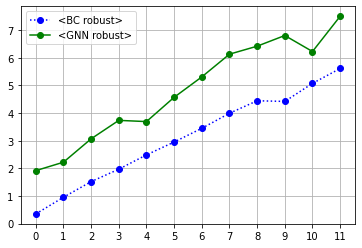

Degree 0: Max(BC robust): 1.00+-0.00; Max(GNN robust): 6.00+-2.16; 
Degree 1: Max(BC robust): 3.00+-0.00; Max(GNN robust): 10.00+-2.83; 
Degree 2: Max(BC robust): 4.00+-0.00; Max(GNN robust): 12.67+-2.36; 
Degree 3: Max(BC robust): 5.00+-0.00; Max(GNN robust): 16.67+-2.49; 
Degree 4: Max(BC robust): 5.67+-0.47; Max(GNN robust): 16.00+-1.63; 
Degree 5: Max(BC robust): 7.00+-0.00; Max(GNN robust): 21.67+-4.11; 
Degree 6: Max(BC robust): 7.33+-0.47; Max(GNN robust): 15.00+-2.16; 
Degree 7: Max(BC robust): 8.33+-0.47; Max(GNN robust): 16.33+-2.49; 
Degree 8: Max(BC robust): 9.33+-0.94; Max(GNN robust): 16.33+-1.25; 
Degree 9: Max(BC robust): 7.67+-0.47; Max(GNN robust): 14.33+-1.70; 
Degree 10: Max(BC robust): 8.00+-0.82; Max(GNN robust): 14.33+-5.44; 
Degree 11: Max(BC robust): 6.67+-3.40; Max(GNN robust): 7.67+-6.13; 
Degree 0: Median(BC robust): 0.17+-0.24; Median(GNN robust): 1.17+-0.62; 
Degree 1: Median(BC robust): 1.00+-0.00; Median(GNN robust): 1.33+-0.47; 
Degree 2: Median(BC robu

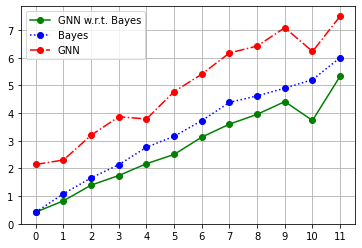

This was K: 1.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 1.5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69367, loss_val: 0.69455, acc_train: 0.47800, acc_val: 0.47800
INFO:root:
Epoch  257: loss_train: 0.32645, loss_val: 0.36040, acc_train: 0.88200, acc_val: 0.84400
INFO:root:
Epoch    0: loss_train: 0.69402, loss_val: 0.69512, acc_train: 0.50400, acc_val: 0.50400
INFO:root:
Epoch  915: loss_train: 0.25974, loss_val: 0.31911, acc_train: 0.89400, acc_val: 0.83400
INFO:root:
Epoch    0: loss_train: 0.69166, loss_val: 0.69186, acc_train: 0.52400, acc_val: 0.52400
INFO:root:
Epoch   45: loss_train: 0.29700, loss_val: 0.34575, acc_train: 0.89000, acc_val: 0.86200


Prediction Statistics:
Count BC: 902.0+-4.2; GNN: 865.7+-3.7
Count Structure BC: 855.7+-9.5; Feature BC: 788.3+-5.0
Count BC and GNN: 835.3+-5.3 
Count BC not GNN: 66.7+-6.6; GNN not BC: 30.3+-4.6
Robustness Statistics:
BC more robust than GNN: 293.3+-38.9
BC & GNN equal robustness: 170.0+-21.3
BC less robust than GNN: 372.0+-37.5
Degree 0: <BC robust>: 0.92+-0.13; <GNN robust>: 1.26+-0.41; 
Degree 1: <BC robust>: 1.59+-0.10; <GNN robust>: 1.87+-0.47; 
Degree 2: <BC robust>: 2.08+-0.07; <GNN robust>: 2.56+-0.30; 
Degree 3: <BC robust>: 2.54+-0.15; <GNN robust>: 3.10+-0.24; 
Degree 4: <BC robust>: 3.03+-0.16; <GNN robust>: 3.31+-0.43; 
Degree 5: <BC robust>: 3.47+-0.03; <GNN robust>: 4.10+-0.09; 
Degree 6: <BC robust>: 3.99+-0.20; <GNN robust>: 4.82+-0.15; 
Degree 7: <BC robust>: 4.51+-0.31; <GNN robust>: 5.55+-0.53; 
Degree 8: <BC robust>: 5.07+-0.53; <GNN robust>: 6.17+-0.47; 
Degree 9: <BC robust>: 5.04+-0.67; <GNN robust>: 6.00+-0.58; 
Degree 10: <BC robust>: 5.59+-0.74; <GNN robust

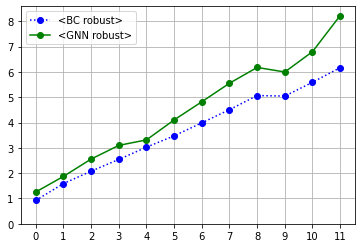

Degree 0: Max(BC robust): 2.67+-0.47; Max(GNN robust): 4.67+-1.70; 
Degree 1: Max(BC robust): 4.67+-0.47; Max(GNN robust): 7.67+-0.47; 
Degree 2: Max(BC robust): 5.33+-0.47; Max(GNN robust): 10.00+-0.82; 
Degree 3: Max(BC robust): 7.00+-0.00; Max(GNN robust): 13.67+-2.05; 
Degree 4: Max(BC robust): 7.00+-0.00; Max(GNN robust): 11.33+-1.70; 
Degree 5: Max(BC robust): 9.00+-0.00; Max(GNN robust): 14.33+-1.25; 
Degree 6: Max(BC robust): 8.33+-0.47; Max(GNN robust): 12.33+-1.25; 
Degree 7: Max(BC robust): 10.00+-0.00; Max(GNN robust): 15.33+-1.70; 
Degree 8: Max(BC robust): 10.67+-1.25; Max(GNN robust): 15.33+-1.25; 
Degree 9: Max(BC robust): 8.67+-0.47; Max(GNN robust): 12.67+-2.62; 
Degree 10: Max(BC robust): 8.33+-0.47; Max(GNN robust): 12.00+-3.27; 
Degree 11: Max(BC robust): 7.33+-3.86; Max(GNN robust): 9.33+-3.40; 
Degree 0: Median(BC robust): 0.50+-0.41; Median(GNN robust): 1.00+-0.00; 
Degree 1: Median(BC robust): 1.33+-0.47; Median(GNN robust): 1.67+-0.47; 
Degree 2: Median(BC rob

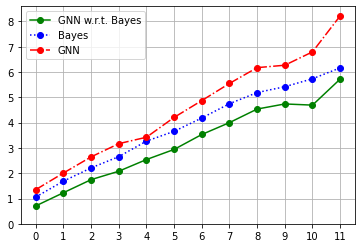

This was K: 1.5.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 2--------------------------


INFO:root:
Epoch    0: loss_train: 0.69312, loss_val: 0.69403, acc_train: 0.47800, acc_val: 0.47800
INFO:root:
Epoch  183: loss_train: 0.23838, loss_val: 0.26873, acc_train: 0.92000, acc_val: 0.88600
INFO:root:
Epoch    0: loss_train: 0.69386, loss_val: 0.69496, acc_train: 0.50400, acc_val: 0.50400
INFO:root:
Epoch  879: loss_train: 0.19318, loss_val: 0.24805, acc_train: 0.92800, acc_val: 0.88600
INFO:root:
Epoch    0: loss_train: 0.69166, loss_val: 0.69186, acc_train: 0.52400, acc_val: 0.52400
INFO:root:
Epoch  952: loss_train: 0.19762, loss_val: 0.25504, acc_train: 0.93400, acc_val: 0.90000


Prediction Statistics:
Count BC: 931.0+-1.6; GNN: 901.0+-1.6
Count Structure BC: 855.7+-9.5; Feature BC: 846.3+-6.9
Count BC and GNN: 880.7+-1.9 
Count BC not GNN: 50.3+-0.9; GNN not BC: 20.3+-3.4
Robustness Statistics:
BC more robust than GNN: 434.3+-51.9
BC & GNN equal robustness: 180.3+-9.9
BC less robust than GNN: 266.0+-43.2
Degree 0: <BC robust>: 1.70+-0.14; <GNN robust>: 0.92+-0.26; 
Degree 1: <BC robust>: 2.27+-0.13; <GNN robust>: 1.75+-0.52; 
Degree 2: <BC robust>: 2.80+-0.11; <GNN robust>: 2.38+-0.28; 
Degree 3: <BC robust>: 3.28+-0.15; <GNN robust>: 2.98+-0.25; 
Degree 4: <BC robust>: 3.73+-0.14; <GNN robust>: 3.21+-0.40; 
Degree 5: <BC robust>: 4.19+-0.06; <GNN robust>: 3.96+-0.10; 
Degree 6: <BC robust>: 4.74+-0.15; <GNN robust>: 4.77+-0.36; 
Degree 7: <BC robust>: 5.27+-0.34; <GNN robust>: 5.47+-0.65; 
Degree 8: <BC robust>: 5.98+-0.65; <GNN robust>: 6.25+-0.49; 
Degree 9: <BC robust>: 5.57+-0.21; <GNN robust>: 5.74+-0.18; 
Degree 10: <BC robust>: 6.19+-0.86; <GNN robust>

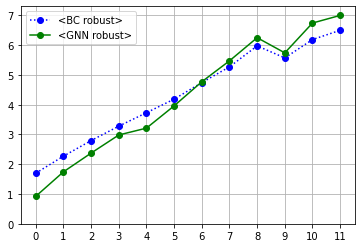

Degree 0: Max(BC robust): 4.00+-0.00; Max(GNN robust): 3.67+-0.47; 
Degree 1: Max(BC robust): 6.33+-0.47; Max(GNN robust): 7.00+-1.41; 
Degree 2: Max(BC robust): 7.33+-0.47; Max(GNN robust): 8.67+-1.25; 
Degree 3: Max(BC robust): 8.67+-0.47; Max(GNN robust): 11.00+-0.82; 
Degree 4: Max(BC robust): 8.67+-0.47; Max(GNN robust): 10.33+-1.25; 
Degree 5: Max(BC robust): 10.67+-0.47; Max(GNN robust): 13.33+-0.47; 
Degree 6: Max(BC robust): 10.00+-0.82; Max(GNN robust): 13.67+-1.25; 
Degree 7: Max(BC robust): 11.33+-0.47; Max(GNN robust): 15.33+-2.36; 
Degree 8: Max(BC robust): 12.00+-1.41; Max(GNN robust): 14.00+-0.82; 
Degree 9: Max(BC robust): 9.67+-0.94; Max(GNN robust): 12.00+-0.82; 
Degree 10: Max(BC robust): 9.33+-0.94; Max(GNN robust): 10.33+-2.49; 
Degree 11: Max(BC robust): 7.67+-4.19; Max(GNN robust): 8.67+-3.40; 
Degree 0: Median(BC robust): 1.50+-0.41; Median(GNN robust): 0.33+-0.24; 
Degree 1: Median(BC robust): 2.00+-0.00; Median(GNN robust): 1.50+-0.41; 
Degree 2: Median(BC ro

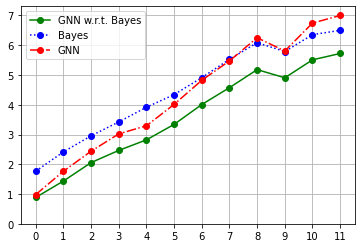

This was K: 2.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 5--------------------------


INFO:root:
Epoch    0: loss_train: 0.68977, loss_val: 0.69091, acc_train: 0.47800, acc_val: 0.47800
INFO:root:
Epoch   47: loss_train: 0.09899, loss_val: 0.11236, acc_train: 0.97400, acc_val: 0.95600
INFO:root:
Epoch    0: loss_train: 0.69290, loss_val: 0.69402, acc_train: 0.50400, acc_val: 0.50400
INFO:root:
Epoch   48: loss_train: 0.08258, loss_val: 0.11294, acc_train: 0.96600, acc_val: 0.96000
INFO:root:
Epoch    0: loss_train: 0.69159, loss_val: 0.69181, acc_train: 0.52400, acc_val: 0.52400
INFO:root:
Epoch   46: loss_train: 0.09252, loss_val: 0.12134, acc_train: 0.96400, acc_val: 0.96000


Prediction Statistics:
Count BC: 996.7+-2.6; GNN: 959.3+-5.0
Count Structure BC: 855.7+-9.5; Feature BC: 995.0+-0.0
Count BC and GNN: 958.7+-5.4 
Count BC not GNN: 38.0+-5.9; GNN not BC: 0.7+-0.5
Robustness Statistics:
BC more robust than GNN: 947.7+-3.7
BC & GNN equal robustness: 7.0+-3.3
BC less robust than GNN: 4.0+-2.2
Degree 0: <BC robust>: 10.52+-0.45; <GNN robust>: 0.57+-0.19; 
Degree 1: <BC robust>: 11.39+-0.28; <GNN robust>: 1.64+-0.37; 
Degree 2: <BC robust>: 12.00+-0.31; <GNN robust>: 2.31+-0.26; 
Degree 3: <BC robust>: 12.43+-0.05; <GNN robust>: 3.15+-0.37; 
Degree 4: <BC robust>: 12.85+-0.24; <GNN robust>: 3.76+-0.35; 
Degree 5: <BC robust>: 13.58+-0.07; <GNN robust>: 4.31+-0.36; 
Degree 6: <BC robust>: 14.07+-0.49; <GNN robust>: 5.08+-0.61; 
Degree 7: <BC robust>: 14.36+-0.94; <GNN robust>: 5.85+-0.59; 
Degree 8: <BC robust>: 15.84+-0.86; <GNN robust>: 6.23+-0.56; 
Degree 9: <BC robust>: 15.10+-0.15; <GNN robust>: 6.58+-1.04; 
Degree 10: <BC robust>: 15.21+-2.19; <GNN rob

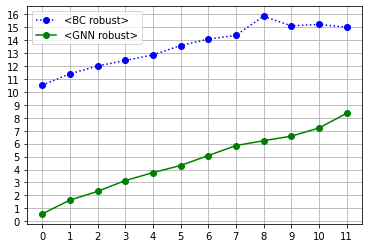

Degree 0: Max(BC robust): 17.67+-0.94; Max(GNN robust): 2.00+-0.82; 
Degree 1: Max(BC robust): 22.33+-1.25; Max(GNN robust): 5.33+-1.25; 
Degree 2: Max(BC robust): 23.00+-0.82; Max(GNN robust): 6.67+-0.47; 
Degree 3: Max(BC robust): 25.00+-0.82; Max(GNN robust): 8.67+-0.94; 
Degree 4: Max(BC robust): 23.67+-1.25; Max(GNN robust): 9.33+-1.70; 
Degree 5: Max(BC robust): 27.00+-0.82; Max(GNN robust): 11.33+-1.25; 
Degree 6: Max(BC robust): 24.00+-0.82; Max(GNN robust): 12.00+-2.16; 
Degree 7: Max(BC robust): 25.67+-0.47; Max(GNN robust): 13.33+-0.47; 
Degree 8: Max(BC robust): 26.33+-2.36; Max(GNN robust): 12.67+-2.49; 
Degree 9: Max(BC robust): 23.00+-1.41; Max(GNN robust): 12.00+-2.45; 
Degree 10: Max(BC robust): 21.00+-4.32; Max(GNN robust): 10.33+-1.25; 
Degree 11: Max(BC robust): 17.00+-6.53; Max(GNN robust): 9.33+-3.09; 
Degree 0: Median(BC robust): 9.83+-0.85; Median(GNN robust): 0.33+-0.47; 
Degree 1: Median(BC robust): 11.67+-0.47; Median(GNN robust): 1.33+-0.47; 
Degree 2: Media

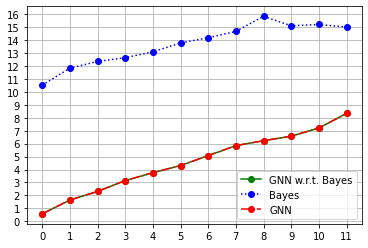

This was K: 5.
----------------------------------------------------------


In [9]:
n = 1000
n_iter = 1000
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
seed_l = [1, 2, 3]
K_l = [0.5, 1, 1.5, 2, 5]
attack_method = "l2"
perform_experiments(n, seed_l, n_iter, avg_intra_degree, avg_inter_degree, K_l, attack_method)

In [204]:
n = 1000
n_iter = 1000
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
seed = 1
perform_experiment(n, seed, n_iter, avg_intra_degree, avg_inter_degree)

INFO:root:
Epoch    0: loss_train: 0.69477, loss_val: 0.69559, acc_train: 0.47800, acc_val: 0.47800
INFO:root:
Epoch  999: loss_train: 0.48493, loss_val: 0.60393, acc_train: 0.80600, acc_val: 0.69400


Prediction Statistics:
Count BC: 867; GNN: 669
Count Structure BC: 864; Feature BC: 581
Count BC and GNN: 615 
Count BC not GNN: 252; GNN not BC: 54
Robustness Statistics:
BC more robust than GNN: 110
BC & GNN equal robustness: 48
BC less robust than GNN: 457
Degree 0: <BC robust>: 0.00; <GNN robust>: 10.89;
Degree 1: <BC robust>: 0.61; <GNN robust>: 7.07;
Degree 2: <BC robust>: 1.19; <GNN robust>: 10.73;
Degree 3: <BC robust>: 1.57; <GNN robust>: 10.74;
Degree 4: <BC robust>: 2.07; <GNN robust>: 14.31;
Degree 5: <BC robust>: 2.58; <GNN robust>: 12.22;
Degree 6: <BC robust>: 2.86; <GNN robust>: 12.29;
Degree 7: <BC robust>: 3.43; <GNN robust>: 19.03;
Degree 8: <BC robust>: 3.94; <GNN robust>: 15.76;
Degree 9: <BC robust>: 4.23; <GNN robust>: 18.57;
Degree 10: <BC robust>: 5.00; <GNN robust>: 28.20;
Degree 11: <BC robust>: 3.00; <GNN robust>: -1.00;
Degree 12: <BC robust>: 8.00; <GNN robust>: 4.50;
Degree 0: Median(BC robust): 0.00; Median(GNN robust): 5.00;
Degree 1: Median(BC robust):

# GAT

In [17]:
model_params = dict(
    label="GAT",
    model="GAT", #GCN or DenseGCN or APPNP
    dropout=0,
    dropout_neighourhood=0,
    n_heads=8
)

train_params = dict(
    loss_type="CE",
    lr=1e-2,
    weight_decay=1e-3,
    patience=300,
    max_epochs=1000,
    use_selftrain = False, 
    use_advtrain = False,
)

# Other
split_params = {
    "strategy": "normal", # or "custom"
    "p_trn": 1,
    "p_tst": 0, # "normal" uses 1 - p_trn, only for custom split strategy
    "p_selftrn": 0 # Refers to unlabeled data, which is not test data, 
                    # only for custom split strategy
}
verbosity_params = dict(
    display_steps = 1001
)   
# Device
device = 0
if not torch.cuda.is_available():
    device == "cpu", "CUDA is not availble, set device to 'cpu'"
else:
    device = torch.device(f"cuda:{device}")
    logging.info(f"Currently on gpu device {device}")
attack_params["data_device"] = device

INFO:root:Currently on gpu device cuda:0


----------------------------------------------------------
--------------------------K: 0.5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69515, loss_val: 0.69386, acc_train: 0.46200, acc_val: 0.49000
INFO:root:
Epoch  100: loss_train: 0.53299, loss_val: 0.65820, acc_train: 0.74800, acc_val: 0.65000
INFO:root:
Epoch  200: loss_train: 0.31791, loss_val: 0.77726, acc_train: 0.89200, acc_val: 0.65600
INFO:root:
Epoch  300: loss_train: 0.24160, loss_val: 0.86925, acc_train: 0.92200, acc_val: 0.67600
INFO:root:
Epoch  400: loss_train: 0.19376, loss_val: 0.92858, acc_train: 0.94400, acc_val: 0.69000
INFO:root:
Epoch  115: loss_train: 0.49938, loss_val: 0.64321, acc_train: 0.77000, acc_val: 0.66800
INFO:root:
Epoch    0: loss_train: 0.68962, loss_val: 0.69262, acc_train: 0.55400, acc_val: 0.49400
INFO:root:
Epoch  100: loss_train: 0.42149, loss_val: 0.57023, acc_train: 0.81600, acc_val: 0.71000
INFO:root:
Epoch  200: loss_train: 0.18503, loss_val: 0.84935, acc_train: 0.95400, acc_val: 0.71400
INFO:root:
Epoch  300: loss_train: 0.13616, loss_val: 0.91502, acc_train: 0.97200, acc_val: 0.71600


Prediction Statistics:
Count BC: 861.3+-9.0; GNN: 659.3+-21.2
Count Structure BC: 855.7+-9.5; Feature BC: 608.7+-9.1
Count BC and GNN: 610.3+-19.5 
Count BC not GNN: 251.0+-18.8; GNN not BC: 49.0+-2.9
Robustness Statistics:
BC more robust than GNN: 187.0+-23.7
BC & GNN equal robustness: 81.3+-7.7
BC less robust than GNN: 342.0+-18.4
Degree 0: <BC robust>: 0.00+-0.00; <GNN robust>: 2.63+-1.38; 
Degree 1: <BC robust>: 0.62+-0.06; <GNN robust>: 22.83+-8.24; 
Degree 2: <BC robust>: 1.16+-0.06; <GNN robust>: 37.61+-28.27; 
Degree 3: <BC robust>: 1.66+-0.10; <GNN robust>: 31.52+-14.18; 
Degree 4: <BC robust>: 2.23+-0.10; <GNN robust>: 34.54+-4.86; 
Degree 5: <BC robust>: 2.63+-0.11; <GNN robust>: 46.86+-9.07; 
Degree 6: <BC robust>: 3.22+-0.08; <GNN robust>: 26.79+-12.05; 
Degree 7: <BC robust>: 3.67+-0.15; <GNN robust>: 56.95+-25.94; 
Degree 8: <BC robust>: 4.05+-0.35; <GNN robust>: 34.84+-6.32; 
Degree 9: <BC robust>: 4.07+-0.64; <GNN robust>: 9.77+-4.88; 
Degree 10: <BC robust>: 4.90+-0.5

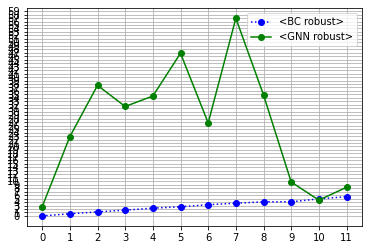

Degree 0: Max(BC robust): 0.00+-0.00; Max(GNN robust): 14.33+-11.15; 
Degree 1: Max(BC robust): 2.00+-0.00; Max(GNN robust): 502.00+-18.83; 
Degree 2: Max(BC robust): 2.67+-0.47; Max(GNN robust): 516.67+-8.99; 
Degree 3: Max(BC robust): 4.00+-0.00; Max(GNN robust): 516.33+-8.81; 
Degree 4: Max(BC robust): 4.67+-0.47; Max(GNN robust): 516.67+-8.99; 
Degree 5: Max(BC robust): 6.00+-0.00; Max(GNN robust): 516.67+-8.99; 
Degree 6: Max(BC robust): 6.33+-0.47; Max(GNN robust): 513.00+-13.49; 
Degree 7: Max(BC robust): 7.33+-0.47; Max(GNN robust): 516.33+-8.73; 
Degree 8: Max(BC robust): 8.33+-0.47; Max(GNN robust): 480.67+-8.06; 
Degree 9: Max(BC robust): 7.33+-0.94; Max(GNN robust): 28.67+-6.60; 
Degree 10: Max(BC robust): 8.33+-0.94; Max(GNN robust): 10.67+-6.55; 
Degree 11: Max(BC robust): 6.33+-3.09; Max(GNN robust): 10.00+-1.00; 
Degree 0: Median(BC robust): 0.00+-0.00; Median(GNN robust): 1.00+-0.82; 
Degree 1: Median(BC robust): 1.00+-0.00; Median(GNN robust): 1.33+-0.47; 
Degree 2: M

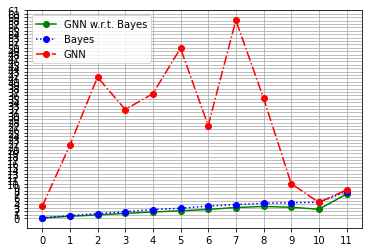

This was K: 0.5.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 1--------------------------


INFO:root:
Epoch    0: loss_train: 0.69593, loss_val: 0.69459, acc_train: 0.45600, acc_val: 0.47200
INFO:root:
Epoch  100: loss_train: 0.42313, loss_val: 0.52567, acc_train: 0.83600, acc_val: 0.75800
INFO:root:
Epoch  200: loss_train: 0.29553, loss_val: 0.57313, acc_train: 0.88400, acc_val: 0.76000
INFO:root:
Epoch  300: loss_train: 0.20751, loss_val: 0.66370, acc_train: 0.93400, acc_val: 0.76000
INFO:root:
Epoch  400: loss_train: 0.17918, loss_val: 0.74363, acc_train: 0.93800, acc_val: 0.73600
INFO:root:
Epoch  105: loss_train: 0.41724, loss_val: 0.52488, acc_train: 0.83400, acc_val: 0.76200
INFO:root:
Epoch    0: loss_train: 0.68821, loss_val: 0.69123, acc_train: 0.57200, acc_val: 0.51400
INFO:root:
Epoch  100: loss_train: 0.36421, loss_val: 0.45784, acc_train: 0.84200, acc_val: 0.77800
INFO:root:
Epoch  200: loss_train: 0.20719, loss_val: 0.57306, acc_train: 0.92400, acc_val: 0.76600
INFO:root:
Epoch  300: loss_train: 0.17463, loss_val: 0.61864, acc_train: 0.94400, acc_val: 0.77200


Prediction Statistics:
Count BC: 881.3+-5.6; GNN: 780.7+-3.1
Count Structure BC: 855.7+-9.5; Feature BC: 703.7+-5.2
Count BC and GNN: 741.7+-6.2 
Count BC not GNN: 139.7+-0.9; GNN not BC: 39.0+-3.7
Robustness Statistics:
BC more robust than GNN: 273.0+-18.0
BC & GNN equal robustness: 126.3+-6.3
BC less robust than GNN: 342.3+-26.5
Degree 0: <BC robust>: 0.35+-0.11; <GNN robust>: 0.99+-0.16; 
Degree 1: <BC robust>: 0.95+-0.07; <GNN robust>: 5.92+-6.38; 
Degree 2: <BC robust>: 1.52+-0.07; <GNN robust>: 13.69+-13.01; 
Degree 3: <BC robust>: 1.97+-0.11; <GNN robust>: 8.62+-1.67; 
Degree 4: <BC robust>: 2.49+-0.12; <GNN robust>: 9.32+-5.86; 
Degree 5: <BC robust>: 2.95+-0.06; <GNN robust>: 19.67+-8.58; 
Degree 6: <BC robust>: 3.45+-0.09; <GNN robust>: 9.61+-6.30; 
Degree 7: <BC robust>: 3.99+-0.18; <GNN robust>: 10.29+-5.20; 
Degree 8: <BC robust>: 4.44+-0.41; <GNN robust>: 25.88+-1.94; 
Degree 9: <BC robust>: 4.42+-0.52; <GNN robust>: 27.98+-30.47; 
Degree 10: <BC robust>: 5.07+-0.57; <GNN

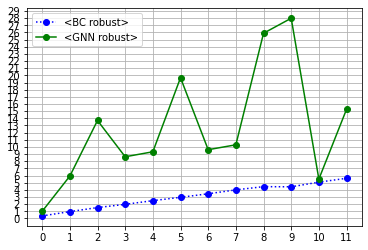

Degree 0: Max(BC robust): 1.00+-0.00; Max(GNN robust): 4.33+-1.25; 
Degree 1: Max(BC robust): 3.00+-0.00; Max(GNN robust): 179.33+-243.72; 
Degree 2: Max(BC robust): 4.00+-0.00; Max(GNN robust): 358.67+-232.40; 
Degree 3: Max(BC robust): 5.00+-0.00; Max(GNN robust): 501.67+-19.26; 
Degree 4: Max(BC robust): 5.67+-0.47; Max(GNN robust): 356.33+-235.00; 
Degree 5: Max(BC robust): 7.00+-0.00; Max(GNN robust): 514.00+-12.75; 
Degree 6: Max(BC robust): 7.33+-0.47; Max(GNN robust): 206.67+-225.81; 
Degree 7: Max(BC robust): 8.33+-0.47; Max(GNN robust): 184.00+-207.92; 
Degree 8: Max(BC robust): 9.33+-0.94; Max(GNN robust): 497.00+-19.51; 
Degree 9: Max(BC robust): 7.67+-0.47; Max(GNN robust): 189.67+-235.06; 
Degree 10: Max(BC robust): 8.00+-0.82; Max(GNN robust): 11.67+-2.87; 
Degree 11: Max(BC robust): 6.67+-3.40; Max(GNN robust): 16.00+-7.00; 
Degree 0: Median(BC robust): 0.17+-0.24; Median(GNN robust): 0.50+-0.41; 
Degree 1: Median(BC robust): 1.00+-0.00; Median(GNN robust): 1.00+-0.00; 

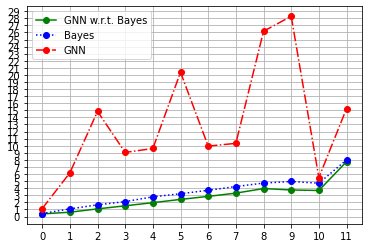

This was K: 1.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 1.5--------------------------


INFO:root:
Epoch    0: loss_train: 0.69671, loss_val: 0.69531, acc_train: 0.43800, acc_val: 0.45800
INFO:root:
Epoch  100: loss_train: 0.34288, loss_val: 0.42296, acc_train: 0.87200, acc_val: 0.82400
INFO:root:
Epoch  200: loss_train: 0.27524, loss_val: 0.44647, acc_train: 0.90200, acc_val: 0.83200
INFO:root:
Epoch  300: loss_train: 0.17820, loss_val: 0.59501, acc_train: 0.93600, acc_val: 0.78000
INFO:root:
Epoch  400: loss_train: 0.12282, loss_val: 0.73644, acc_train: 0.96600, acc_val: 0.76400
INFO:root:
Epoch  135: loss_train: 0.32559, loss_val: 0.41789, acc_train: 0.87400, acc_val: 0.82600
INFO:root:
Epoch    0: loss_train: 0.68681, loss_val: 0.68984, acc_train: 0.58200, acc_val: 0.54200
INFO:root:
Epoch  100: loss_train: 0.28005, loss_val: 0.35759, acc_train: 0.90000, acc_val: 0.84400
INFO:root:
Epoch  200: loss_train: 0.20594, loss_val: 0.42421, acc_train: 0.91400, acc_val: 0.82600
INFO:root:
Epoch  300: loss_train: 0.13395, loss_val: 0.52187, acc_train: 0.96200, acc_val: 0.80400


Prediction Statistics:
Count BC: 902.0+-4.2; GNN: 846.0+-2.9
Count Structure BC: 855.7+-9.5; Feature BC: 788.3+-5.0
Count BC and GNN: 815.7+-7.4 
Count BC not GNN: 86.3+-3.9; GNN not BC: 30.3+-4.5
Robustness Statistics:
BC more robust than GNN: 398.7+-36.7
BC & GNN equal robustness: 148.3+-5.3
BC less robust than GNN: 268.7+-41.5
Degree 0: <BC robust>: 0.92+-0.13; <GNN robust>: 0.78+-0.14; 
Degree 1: <BC robust>: 1.59+-0.10; <GNN robust>: 1.30+-0.30; 
Degree 2: <BC robust>: 2.08+-0.07; <GNN robust>: 5.83+-3.24; 
Degree 3: <BC robust>: 2.54+-0.15; <GNN robust>: 5.52+-2.53; 
Degree 4: <BC robust>: 3.03+-0.16; <GNN robust>: 5.84+-2.66; 
Degree 5: <BC robust>: 3.47+-0.03; <GNN robust>: 12.77+-6.59; 
Degree 6: <BC robust>: 3.99+-0.20; <GNN robust>: 6.29+-2.52; 
Degree 7: <BC robust>: 4.51+-0.31; <GNN robust>: 8.47+-4.62; 
Degree 8: <BC robust>: 5.07+-0.53; <GNN robust>: 18.33+-6.40; 
Degree 9: <BC robust>: 5.04+-0.67; <GNN robust>: 8.49+-3.24; 
Degree 10: <BC robust>: 5.59+-0.74; <GNN robus

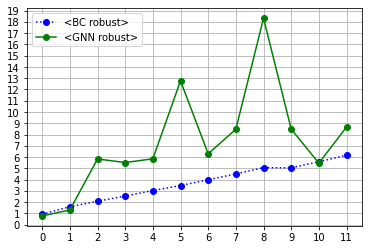

Degree 0: Max(BC robust): 2.67+-0.47; Max(GNN robust): 3.33+-0.47; 
Degree 1: Max(BC robust): 4.67+-0.47; Max(GNN robust): 8.33+-2.49; 
Degree 2: Max(BC robust): 5.33+-0.47; Max(GNN robust): 339.00+-229.87; 
Degree 3: Max(BC robust): 7.00+-0.00; Max(GNN robust): 337.33+-231.55; 
Degree 4: Max(BC robust): 7.00+-0.00; Max(GNN robust): 336.67+-232.49; 
Degree 5: Max(BC robust): 9.00+-0.00; Max(GNN robust): 342.33+-225.17; 
Degree 6: Max(BC robust): 8.33+-0.47; Max(GNN robust): 172.33+-214.86; 
Degree 7: Max(BC robust): 10.00+-0.00; Max(GNN robust): 177.00+-212.49; 
Degree 8: Max(BC robust): 10.67+-1.25; Max(GNN robust): 330.33+-217.42; 
Degree 9: Max(BC robust): 8.67+-0.47; Max(GNN robust): 37.33+-23.01; 
Degree 10: Max(BC robust): 8.33+-0.47; Max(GNN robust): 10.67+-2.87; 
Degree 11: Max(BC robust): 7.33+-3.86; Max(GNN robust): 9.67+-7.59; 
Degree 0: Median(BC robust): 0.50+-0.41; Median(GNN robust): 0.00+-0.00; 
Degree 1: Median(BC robust): 1.33+-0.47; Median(GNN robust): 1.00+-0.00; 
D

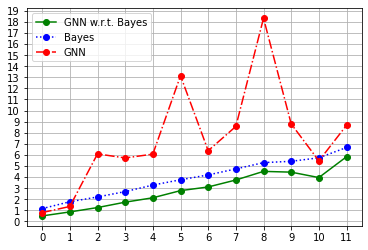

This was K: 1.5.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 2--------------------------


INFO:root:
Epoch    0: loss_train: 0.69749, loss_val: 0.69604, acc_train: 0.42600, acc_val: 0.45200
INFO:root:
Epoch  100: loss_train: 0.28181, loss_val: 0.34233, acc_train: 0.89200, acc_val: 0.86400
INFO:root:
Epoch  200: loss_train: 0.23786, loss_val: 0.35082, acc_train: 0.91200, acc_val: 0.86600
INFO:root:
Epoch  300: loss_train: 0.17278, loss_val: 0.47777, acc_train: 0.94600, acc_val: 0.83400
INFO:root:
Epoch  400: loss_train: 0.12832, loss_val: 0.58799, acc_train: 0.96600, acc_val: 0.81000
INFO:root:
Epoch  136: loss_train: 0.27127, loss_val: 0.33343, acc_train: 0.89400, acc_val: 0.87400
INFO:root:
Epoch    0: loss_train: 0.68540, loss_val: 0.68845, acc_train: 0.60200, acc_val: 0.56800
INFO:root:
Epoch  100: loss_train: 0.22086, loss_val: 0.29491, acc_train: 0.92600, acc_val: 0.88200
INFO:root:
Epoch  200: loss_train: 0.20754, loss_val: 0.31273, acc_train: 0.92400, acc_val: 0.87600
INFO:root:
Epoch  300: loss_train: 0.12647, loss_val: 0.43618, acc_train: 0.95400, acc_val: 0.85000


Prediction Statistics:
Count BC: 931.0+-1.6; GNN: 880.0+-5.9
Count Structure BC: 855.7+-9.5; Feature BC: 846.3+-6.9
Count BC and GNN: 860.7+-4.8 
Count BC not GNN: 70.3+-3.3; GNN not BC: 19.3+-1.2
Robustness Statistics:
BC more robust than GNN: 557.7+-34.0
BC & GNN equal robustness: 124.7+-6.8
BC less robust than GNN: 178.3+-44.9
Degree 0: <BC robust>: 1.70+-0.14; <GNN robust>: 0.43+-0.17; 
Degree 1: <BC robust>: 2.27+-0.13; <GNN robust>: 1.01+-0.23; 
Degree 2: <BC robust>: 2.80+-0.11; <GNN robust>: 1.50+-0.07; 
Degree 3: <BC robust>: 3.28+-0.15; <GNN robust>: 2.27+-0.18; 
Degree 4: <BC robust>: 3.73+-0.14; <GNN robust>: 2.81+-0.41; 
Degree 5: <BC robust>: 4.19+-0.06; <GNN robust>: 7.89+-6.19; 
Degree 6: <BC robust>: 4.74+-0.15; <GNN robust>: 4.25+-0.58; 
Degree 7: <BC robust>: 5.27+-0.34; <GNN robust>: 5.03+-0.98; 
Degree 8: <BC robust>: 5.98+-0.65; <GNN robust>: 12.42+-8.06; 
Degree 9: <BC robust>: 5.57+-0.21; <GNN robust>: 6.63+-1.08; 
Degree 10: <BC robust>: 6.19+-0.86; <GNN robust

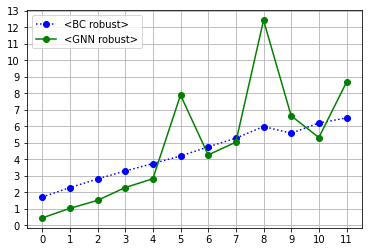

Degree 0: Max(BC robust): 4.00+-0.00; Max(GNN robust): 2.33+-0.94; 
Degree 1: Max(BC robust): 6.33+-0.47; Max(GNN robust): 6.67+-1.25; 
Degree 2: Max(BC robust): 7.33+-0.47; Max(GNN robust): 14.33+-6.13; 
Degree 3: Max(BC robust): 8.67+-0.47; Max(GNN robust): 23.00+-11.05; 
Degree 4: Max(BC robust): 8.67+-0.47; Max(GNN robust): 18.33+-8.73; 
Degree 5: Max(BC robust): 10.67+-0.47; Max(GNN robust): 190.67+-235.84; 
Degree 6: Max(BC robust): 10.00+-0.82; Max(GNN robust): 17.33+-5.56; 
Degree 7: Max(BC robust): 11.33+-0.47; Max(GNN robust): 24.00+-8.52; 
Degree 8: Max(BC robust): 12.00+-1.41; Max(GNN robust): 178.33+-221.83; 
Degree 9: Max(BC robust): 9.67+-0.94; Max(GNN robust): 19.33+-4.50; 
Degree 10: Max(BC robust): 9.33+-0.94; Max(GNN robust): 10.00+-2.16; 
Degree 11: Max(BC robust): 7.67+-4.19; Max(GNN robust): 9.67+-6.65; 
Degree 0: Median(BC robust): 1.50+-0.41; Median(GNN robust): 0.00+-0.00; 
Degree 1: Median(BC robust): 2.00+-0.00; Median(GNN robust): 0.67+-0.47; 
Degree 2: Medi

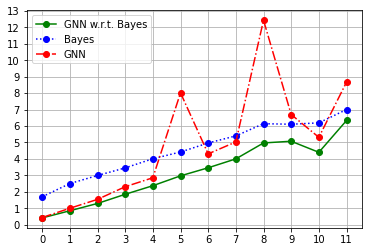

This was K: 2.
----------------------------------------------------------
----------------------------------------------------------
--------------------------K: 5--------------------------


INFO:root:
Epoch    0: loss_train: 0.70217, loss_val: 0.70040, acc_train: 0.34400, acc_val: 0.36400
INFO:root:
Epoch  100: loss_train: 0.15459, loss_val: 0.20091, acc_train: 0.95000, acc_val: 0.92600
INFO:root:
Epoch  200: loss_train: 0.13390, loss_val: 0.19898, acc_train: 0.95800, acc_val: 0.93400
INFO:root:
Epoch  300: loss_train: 0.10486, loss_val: 0.20233, acc_train: 0.97600, acc_val: 0.94200
INFO:root:
Epoch  400: loss_train: 0.07824, loss_val: 0.22516, acc_train: 0.98200, acc_val: 0.94000
INFO:root:
Epoch  500: loss_train: 0.07514, loss_val: 0.23117, acc_train: 0.98200, acc_val: 0.94200
INFO:root:
Epoch  268: loss_train: 0.11696, loss_val: 0.19607, acc_train: 0.97000, acc_val: 0.93800
INFO:root:
Epoch    0: loss_train: 0.67699, loss_val: 0.68011, acc_train: 0.70400, acc_val: 0.68200
INFO:root:
Epoch  100: loss_train: 0.09710, loss_val: 0.17377, acc_train: 0.96400, acc_val: 0.93400
INFO:root:
Epoch  200: loss_train: 0.05821, loss_val: 0.16528, acc_train: 0.98600, acc_val: 0.94400


Prediction Statistics:
Count BC: 996.7+-2.6; GNN: 942.0+-15.3
Count Structure BC: 855.7+-9.5; Feature BC: 995.0+-0.0
Count BC and GNN: 941.3+-15.4 
Count BC not GNN: 55.3+-12.8; GNN not BC: 0.7+-0.5
Robustness Statistics:
BC more robust than GNN: 873.3+-73.6
BC & GNN equal robustness: 13.3+-12.5
BC less robust than GNN: 54.7+-71.0
Degree 0: <BC robust>: 10.52+-0.45; <GNN robust>: 0.16+-0.10; 
Degree 1: <BC robust>: 11.39+-0.28; <GNN robust>: 1.38+-0.60; 
Degree 2: <BC robust>: 12.00+-0.31; <GNN robust>: 3.04+-1.86; 
Degree 3: <BC robust>: 12.43+-0.05; <GNN robust>: 4.54+-3.02; 
Degree 4: <BC robust>: 12.85+-0.24; <GNN robust>: 4.88+-1.94; 
Degree 5: <BC robust>: 13.58+-0.07; <GNN robust>: 6.34+-2.77; 
Degree 6: <BC robust>: 14.07+-0.49; <GNN robust>: 7.24+-2.91; 
Degree 7: <BC robust>: 14.36+-0.94; <GNN robust>: 7.56+-2.33; 
Degree 8: <BC robust>: 15.84+-0.86; <GNN robust>: 15.67+-11.68; 
Degree 9: <BC robust>: 15.10+-0.15; <GNN robust>: 7.85+-2.73; 
Degree 10: <BC robust>: 15.21+-2.19

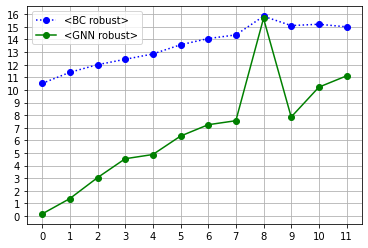

Degree 0: Max(BC robust): 17.67+-0.94; Max(GNN robust): 1.67+-0.94; 
Degree 1: Max(BC robust): 22.33+-1.25; Max(GNN robust): 7.67+-3.09; 
Degree 2: Max(BC robust): 23.00+-0.82; Max(GNN robust): 21.00+-16.27; 
Degree 3: Max(BC robust): 25.00+-0.82; Max(GNN robust): 176.00+-226.29; 
Degree 4: Max(BC robust): 23.67+-1.25; Max(GNN robust): 35.00+-26.24; 
Degree 5: Max(BC robust): 27.00+-0.82; Max(GNN robust): 58.67+-32.66; 
Degree 6: Max(BC robust): 24.00+-0.82; Max(GNN robust): 32.00+-20.54; 
Degree 7: Max(BC robust): 25.67+-0.47; Max(GNN robust): 30.00+-18.67; 
Degree 8: Max(BC robust): 26.33+-2.36; Max(GNN robust): 176.00+-223.45; 
Degree 9: Max(BC robust): 23.00+-1.41; Max(GNN robust): 17.67+-4.50; 
Degree 10: Max(BC robust): 21.00+-4.32; Max(GNN robust): 18.33+-9.74; 
Degree 11: Max(BC robust): 17.00+-6.53; Max(GNN robust): 12.00+-4.90; 
Degree 0: Median(BC robust): 9.83+-0.85; Median(GNN robust): 0.00+-0.00; 
Degree 1: Median(BC robust): 11.67+-0.47; Median(GNN robust): 1.00+-0.00; 


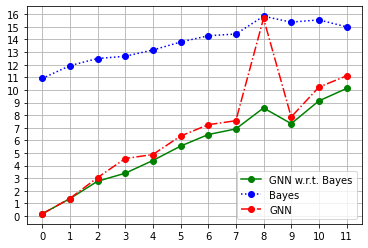

This was K: 5.
----------------------------------------------------------


In [18]:
n = 1000
n_iter = 1000
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
seed_l = [1, 2, 3]
K_l = [0.5, 1, 1.5, 2, 5]
attack_method = "l2"
perform_experiments(n, seed_l, n_iter, avg_intra_degree, avg_inter_degree, K_l, attack_method)